[![image-1.png](https://i.postimg.cc/Dw0ChHKk/image-1.png)](https://postimg.cc/LJdkByXN)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогноз музыкального жанра</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Музыкальный стриминговый сервис "МиФаСоль"
    
__Описание задачи:__ Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

__Постановка задачи:__ Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
    
__Описание данных:__
    
- файл `train.csv` информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
    
- файл `test.csv` информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных.
    
__Описание полей данных:__
    
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- __music_genre__ - музыкальный жанр (целевой признак)

__Оценка результата:__ в данной задаче мы будем использовать метрику f1_micro для оценки качества модели.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [3]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold
import optuna

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

# константы
RANDOM_SEED = 42

# настройки блокнота
random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

In [4]:
# загрузка информации для обучения:
try:
    train = pd.read_csv('data/train.csv')
    print('Информация для обучения:')
    display(train.head(2))
    display(train.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test = pd.read_csv('data/test.csv')
    print('Информация для тестирования:')
    display(test.head(2))
    display(test.info())
except:
    print('Информация для тестирования не доступна')

Информация для обучения:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

Информация для тестирования:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

- `obtained_date`: дата загрузки в сервис, не может влиять на жанр, удаляем этот признак.
- `valence`: привлекательность произведения для пользователей сервиса, так же является субективной мерой, исключаем из дальнейшего анализа,
- `instance_id`: уникальный идентификатор трека, после проверки на уникальность, и преобразования в цельночисленный формат будут переведены в индекс.

In [5]:
# удаляем столбцы 'obtained_date' и 'valence' из обучающего и тестового наборов данных
train = train.drop(['obtained_date', 'valence'], axis=1)
test = test.drop(['obtained_date', 'valence'], axis=1)

__Проверим дубликатов в данных:__

In [6]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in [train, test])}')

Общее количество дубликатов в данных: 0


__Проверим уникальность значений признака `instance_id`__

In [7]:
if all(len(df['instance_id'].unique()) == len(df) for df in [train, test]):
    print('Признак instance_id содержит уникальные значения в обоих датасетах')
else: print('Признак instance_id содержит дублирующиеся значения')

Признак instance_id содержит уникальные значения в обоих датасетах


In [8]:
# преобразуем тип данных столбца 'instance_id' в целочисленный
train['instance_id'] = train['instance_id'].astype(int)
test['instance_id'] = test['instance_id'].astype(int)
# устанавливаем признак 'instance_id' в качестве индекса для обучающего и тестового наборов данных
train.set_index('instance_id', inplace=True)
test.set_index('instance_id', inplace=True)

>- Исключены из анализа признаки `obtained_date` и `valence`
>- Признак `instance_id` установлен в качестве индекса

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ числовых признаков

</div>

In [9]:
# общая информация
train.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


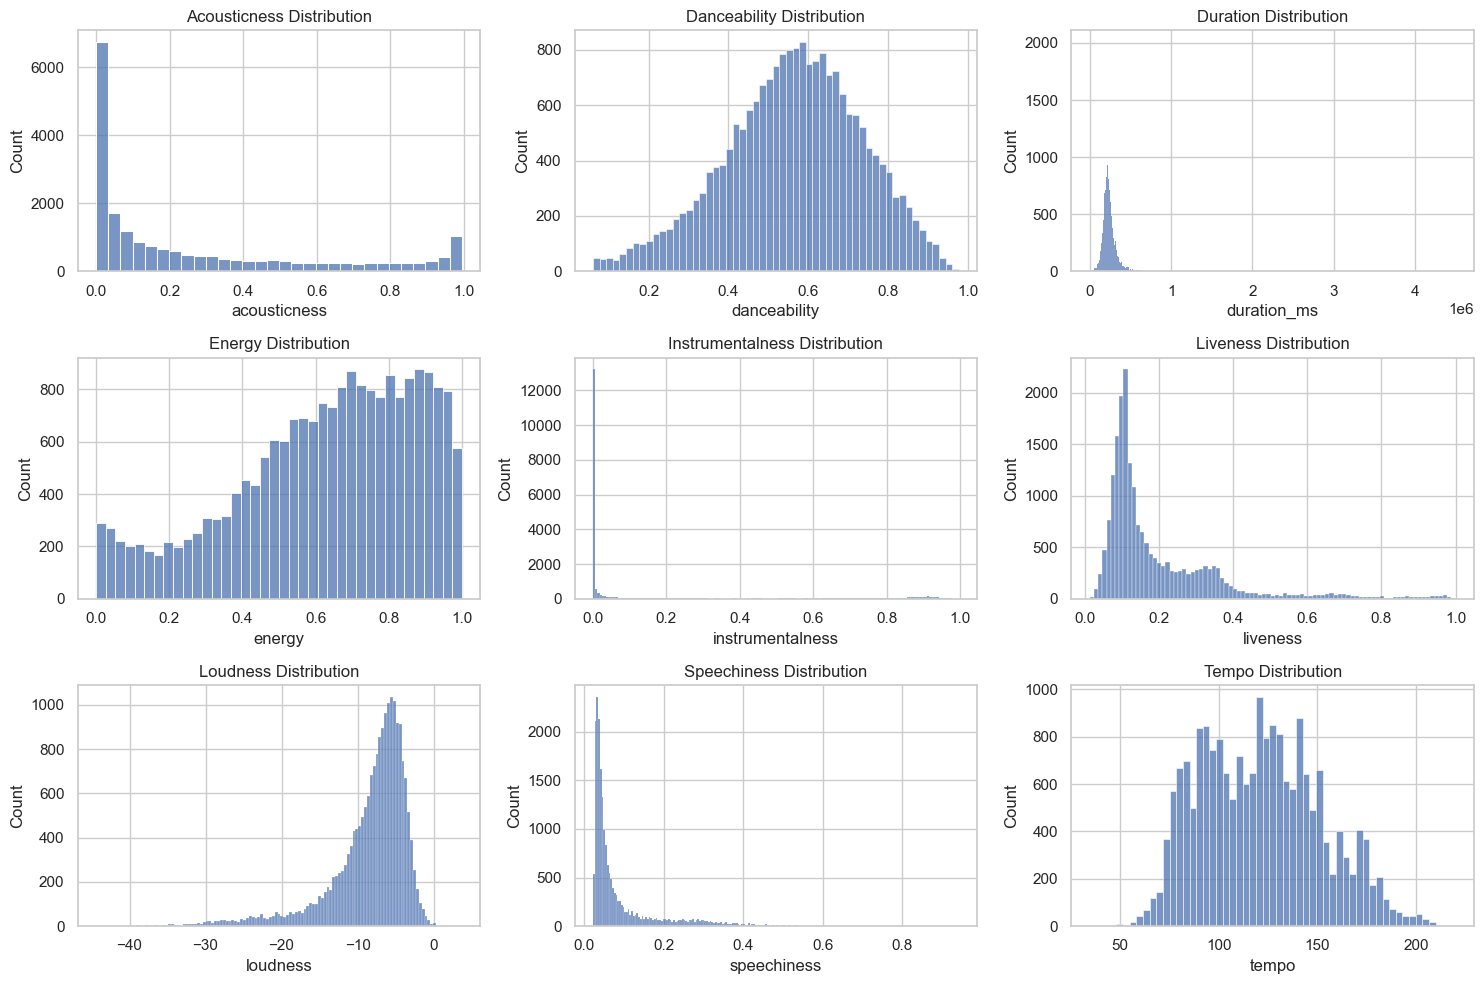

In [10]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# гистограмма для 'acousticness'
sns.histplot(train['acousticness'], ax=axes[0, 0])
axes[0, 0].set_title('Acousticness Distribution')

# гистограмма для для 'danceability'
sns.histplot(train['danceability'], ax=axes[0, 1])
axes[0, 1].set_title('Danceability Distribution')

# гистограмма для для 'duration_ms'
sns.histplot(train['duration_ms'], ax=axes[0, 2])
axes[0, 2].set_title('Duration Distribution')

# гистограмма для для 'energy'
sns.histplot(train['energy'], ax=axes[1, 0])
axes[1, 0].set_title('Energy Distribution')

# гистограмма для для 'instrumentalness'
sns.histplot(train['instrumentalness'], ax=axes[1, 1])
axes[1, 1].set_title('Instrumentalness Distribution')

# гистограмма для для 'liveness'
sns.histplot(train['liveness'], ax=axes[1, 2])
axes[1, 2].set_title('Liveness Distribution')

# гистограмма для для 'loudness'
sns.histplot(train['loudness'], ax=axes[2, 0])
axes[2, 0].set_title('Loudness Distribution')

# гистограмма для для 'speechiness'
sns.histplot(train['speechiness'], ax=axes[2, 1])
axes[2, 1].set_title('Speechiness Distribution')

# гистограмма для для 'tempo'
sns.histplot(train['tempo'], ax=axes[2, 2])
axes[2, 2].set_title('Tempo Distribution')

# графики
plt.tight_layout()
plt.show()


### duration_ms: продолжительность в милисекундах

В данных присутствуют отрицательные значения и крайне длинные треки:

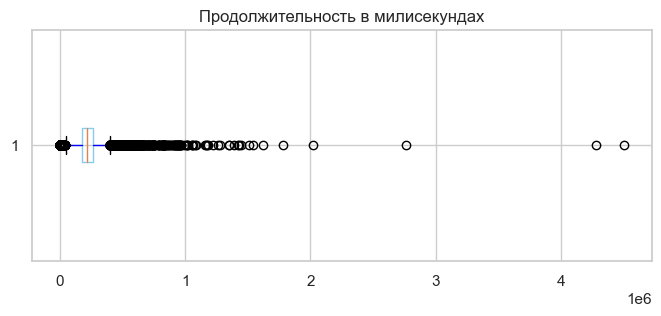

In [11]:
# boxplot для признака vehicle_age
plt.figure(figsize=(8,3))
plt.boxplot(train['duration_ms'], vert=False, boxprops=dict(color='skyblue'), whiskerprops=dict(color='blue'))
plt.grid(True)
plt.title('Продолжительность в милисекундах')
plt.show()

In [12]:
# рассчет верхнего порога аномальных значений
q1 = train['duration_ms'].quantile(0.25)
q3 = train['duration_ms'].quantile(0.75)
upper_threshold = int(q3+3*(q3-q1))
print(f'Порог аномальных значений: {upper_threshold} милисекунд')
# рассчитываем нижний порог для аномальных значений
lower_threshold = q1 - 2*(q3 - q1)
print(f'Нижний порог аномальных значений: {int(lower_threshold)} миллисекунд')

Порог аномальных значений: 531449 милисекунд
Нижний порог аномальных значений: 551 миллисекунд


__Обработка аномальных значений__

In [13]:
# заменяем значения ниже нижнего порога
train['duration_ms'] = np.where(train['duration_ms'] < lower_threshold, lower_threshold, train['duration_ms'])
# заменяем значения выше верхнего порога
train['duration_ms'] = np.where(train['duration_ms'] > upper_threshold, upper_threshold, train['duration_ms'])

# заменяем значения ниже нижнего порога
test['duration_ms'] = np.where(test['duration_ms'] < lower_threshold, lower_threshold, test['duration_ms'])
# заменяем значения выше верхнего порога
test['duration_ms'] = np.where(test['duration_ms'] > upper_threshold, upper_threshold, test['duration_ms'])

__Преобразуем тип данных столбца 'duration_ms' в целочисленный__

In [14]:
train['duration_ms'] = train['duration_ms'].astype(int)
test['duration_ms'] = test['duration_ms'].astype(int)

>Все остальные числовые данные, включая "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", и "speechiness", "tempo", укладываются в пределы допустимых значений и варьируются в рамках нормальных диапазонов для соответствующих музыкальных характеристик. Нет никаких явных аномалий в этих признаках, и они соответствуют типичным значениям для музыкальных данных.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ категориальные признаков

</div>
Проверим уникальные значения в категориальных признаков.

In [15]:
# общая информация 
display(train.describe(include=[object]).T)

,count,unique,top,freq
track_name,20394,18643,Home,11
key,19659,12,G,2304
mode,19888,2,Major,12828
music_genre,20394,10,Blues,2858


__Уникальные значения признака `key`__

In [16]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

>Эти значения представляют собой ноты или аккорды, которые могут быть частью музыкальных произведений. Они соответствуют музыкальным элементам и могут использоваться для определения характера и мелодических особенностей треков.

### Баланс целевой переменной

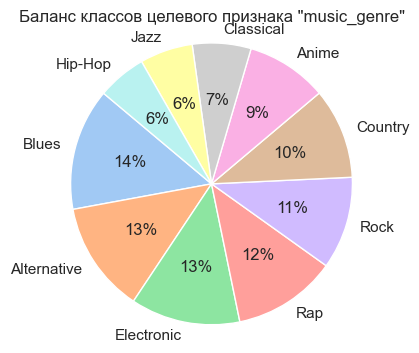

In [17]:
# количество каждого класса
data = train['music_genre'].value_counts()

# метоки классов
labels = data.index
sizes = data.values
colors = sns.color_palette('pastel')

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title('Баланс классов целевого признака "music_genre"')
plt.axis('equal')

# отображение диаграммы
plt.show()

>Баланс классов для целевого признака "music_genre" в тренировочных данных не показывает сильного дисбаланса. Визуализация круговой диаграммы показывает, что классы достаточно равномерно представлены в данных, что является положительным для задачи классификации. Нет явного доминирования одного класса над другим, что упрощает обучение модели и ее способность делать предсказания для разных жанров музыки.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Пропуски в данных

</div>

In [18]:
# функция для рассчето количества пропусков
def isna_sum(df):
    print('Признаки содержащие пропуски:')
    for col in df.columns:
        if df[col].isna().sum()>0:
            print(f'{col}: {df[col].isna().mean():.2%}')

In [19]:
# пропуски в данных для обучения
isna_sum(train)

Признаки содержащие пропуски:
key: 3.60%
mode: 2.48%
tempo: 2.17%


In [20]:
# пропуски в данных для тестирования
isna_sum(test)

Признаки содержащие пропуски:
key: 3.10%
mode: 2.92%
tempo: 2.37%


>Пропуски в данных присутствуют как в тренировочном, так и тестовом наборе данных.
>С учетом того, что удалить данные из тестового набора данных в данной задаче нельзя, попробуем выработать стратегию по заполнению пропусков:
>- создадим копию тренировочного датасета
>- удалим пропуски
>- проверим взаимосвязь признаков

In [21]:
# копия датасета без пропусков
df = train.dropna()

print(f'Общее количество пропусков в данных: {sum(df.isna().sum())}')

Общее количество пропусков в данных: 0


### Корреляции между признаками

Метод PHIK - это статистический метод для определения взаимосвязей между категориальными переменными. Он разработан на основе корреляционного анализа, но специально адаптирован для работы с категориальными данными, которые обычно представлены в виде таблиц сопряженности.

In [23]:
phik_overview = df[[col for col in df.columns if col != 'track_name']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,music_genre
acousticness,1.000000,0.458387,0.295598,0.766578,0.442590,0.096909,0.188614,0.710162,0.026286,0.207558,0.335410,0.658403
danceability,0.458387,1.000000,0.301808,0.515209,0.339896,0.103118,0.132911,0.480074,0.100629,0.336219,0.407936,0.623712
duration_ms,0.295598,0.301808,1.000000,0.305998,0.362986,0.049564,0.152866,0.359252,0.046175,0.217156,0.139921,0.422337
energy,0.766578,0.515209,0.305998,1.000000,0.438574,0.090880,0.260662,0.838452,0.033019,0.239170,0.388336,0.671806
instrumentalness,0.442590,0.339896,0.362986,0.438574,1.000000,0.029922,0.138975,0.498535,0.087474,0.190471,0.217914,0.568069
key,0.096909,0.103118,0.049564,0.090880,0.029922,1.000000,0.057933,0.080208,0.357610,0.117888,0.039206,0.170758
liveness,0.188614,0.132911,0.152866,0.260662,0.138975,0.057933,1.000000,0.202501,0.031851,0.140039,0.082196,0.207030
loudness,0.710162,0.480074,0.359252,0.838452,0.498535,0.080208,0.202501,1.000000,0.019127,0.208318,0.357106,0.679765
mode,0.026286,0.100629,0.046175,0.033019,0.087474,0.357610,0.031851,0.019127,1.000000,0.107284,0.008667,0.295554
speechiness,0.207558,0.336219,0.217156,0.239170,0.190471,0.117888,0.140039,0.208318,0.107284,1.000000,0.185911,0.497169


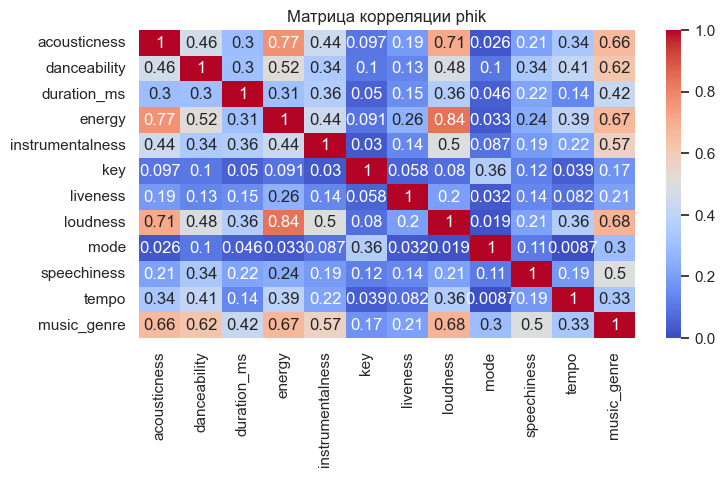

In [24]:
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

>Существует сильная кореляция между признаками energy и loudness, что может указывать на мультиколинеарность, в процессе разработки модели, возможно исключение признака energy, тк данный признак менее связан с целевым.

### Пропуски в данных признака `tempo`

Попробуем построить модель LinearRegression для предсказания данного признака на основе данных и наибольшей кореляцией

In [25]:
tempo_df = df[['acousticness', 'danceability', 'energy', 'loudness', 'tempo']]

In [26]:
display(tempo_df.head(2))

,acousticness,danceability,energy,loudness,tempo
instance_id,,,,,
25143,0.480,0.670,0.351,-16.842,101.384
26091,0.243,0.452,0.670,-8.392,113.071


In [27]:
# выбор признаков и целевой переменной
X = tempo_df.drop('tempo', axis=1)
y = tempo_df['tempo']

# разделение данных на тренировочный и тестовый наборы (например, 80% на тренировку и 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# построение модели регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# предсказание значений "tempo" для тестового набора данных
y_pred = model.predict(X_test_scaled)

# оценка производительности модели
mse = mean_squared_error(y_test, y_pred)

print(f'Root Mean Square Error (RMSE): {mse**0.5}')

Root Mean Square Error (RMSE): 28.94147637341431


Оценим производительность модели, которая просто предсказывает медиану и сравним с обученной ранее моделью

In [28]:
# вычисление медианы на тренировочном наборе данных
median_tempo = np.median(y_train)

# воздание массива предсказаний, в котором каждое предсказание равно медиане
static_predictions = np.full_like(y_test, median_tempo)

# оценка производительности статичной модели
static_mse = mean_squared_error(y_test, static_predictions)

print(f'Static Model Root Mean Square Error (RMSE): {static_mse**0.5}')

Static Model Root Mean Square Error (RMSE): 30.29873804566274


> Модель LinearRegression дает прирост в точности.Обучим модель на всех данных и заполним пропуски

In [29]:
# стандартизация признаков
X = scaler.fit_transform(X)
# итоговая модель
model.fit(X, y)

LinearRegression()

__Заполнение пропусков__

In [30]:
def fill_missing_tempo(dataset, model, scaler):
    # строки с пропущенными значениями 'tempo'
    missing_tempo_rows = dataset[dataset['tempo'].isnull()]

    for index, row in missing_tempo_rows.iterrows():
        # извлечение признаков из строки с пропущенным 'tempo'
        features = row[['acousticness', 'danceability', 'energy', 'loudness']].values.reshape(1, -1)
        # стандартизация признаков
        features_scaled = scaler.transform(features)
        # предсказание 'tempo' с использованием обученной модели
        predicted_tempo = model.predict(features_scaled)
        # запись предсказанного значения вместо пропуска
        dataset.at[index, 'tempo'] = predicted_tempo[0]

    return dataset

In [31]:
# заполнение пропусков в train
train = fill_missing_tempo(train, model, scaler)
# заполнение пропусков в test
test = fill_missing_tempo(test, model, scaler)

### Пропуски в данных признака `mode`

Так как с этими признаками нет достаточно корелируемых признаков заполним пропуски,наиболее частым значением.

In [32]:
# заполняем пропуски наиболее частым значением
train['mode'].fillna(fill_missing_tempo, inplace=True)
test['mode'].fillna(fill_missing_tempo, inplace=True)

### Пропуски в данных признака `key`

Так как с этими признаками не достаточно корелируемых признаков заполним пропуски, значением 'no_info'.

In [33]:
# заполняем пропуски значением 'no_info'
train['key'].fillna('no_info', inplace=True)
test['key'].fillna('no_info', inplace=True)

__Проверим пропуски в данных:__

In [34]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in [train, test])}')

Общее количество пропусков в данных: 0


- Мы рассмотрели данные о музыкальных треках, включая различные характеристики, такие как акустичность, танцевальность, энергичность и другие.
   - Выполнили предварительную обработку данных, удалив ненужные признаки, такие как 'obtained_date' и 'valence'.
   - Провели анализ числовых данных и выявили аномалии в столбце 'duration_ms', которые были успешно обработаны.
- Заполнение пропусков:
   - Для признака 'tempo' мы использовали обученную модель регрессии для предсказания пропущенных значений, на основе других характеристик.
   - Для признака 'mode' мы заполнили пропуски наиболее часто встречающимся значением 'Major', так как у нас не было достаточно коррелирующих признаков для предсказания.
- Баланс целевого признака:
   - Мы оценили баланс целевого признака 'music_genre' и убедились, что в данных нет сильного дисбаланса между классами.


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Модели

</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- LogisticRegression


__Метрика качества:__ f1_micro

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Feature Engineering

</div>

### track_name

In [32]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import notebook, tqdm
import transformers
from torch.utils.data import DataLoader
import transformers
from torch.nn.utils.rnn import pad_sequence

In [34]:
# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация токенизатора, конфигурации и модели BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


__Данные для обучения__

In [35]:
# данные
text_data = train['track_name'] 
batch_size = 1

In [36]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [37]:
# получение эмбеддингов от BERT
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())


  0%|          | 0/20394 [00:00<?, ?it/s]

__Данные для тестирования__

In [278]:
# данные
text_data = test['track_name'] 
batch_size = 1

In [279]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [280]:
# получение эмбеддингов от BERT
embeddings_test = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings_test.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/5099 [00:00<?, ?it/s]

__Сокращения размерности__

In [38]:
# Создание слоя для сокращения размерности до 20
class LinearReducer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReducer, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.relu1 = nn.ReLU()


    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        return x

In [39]:
inp = 10

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


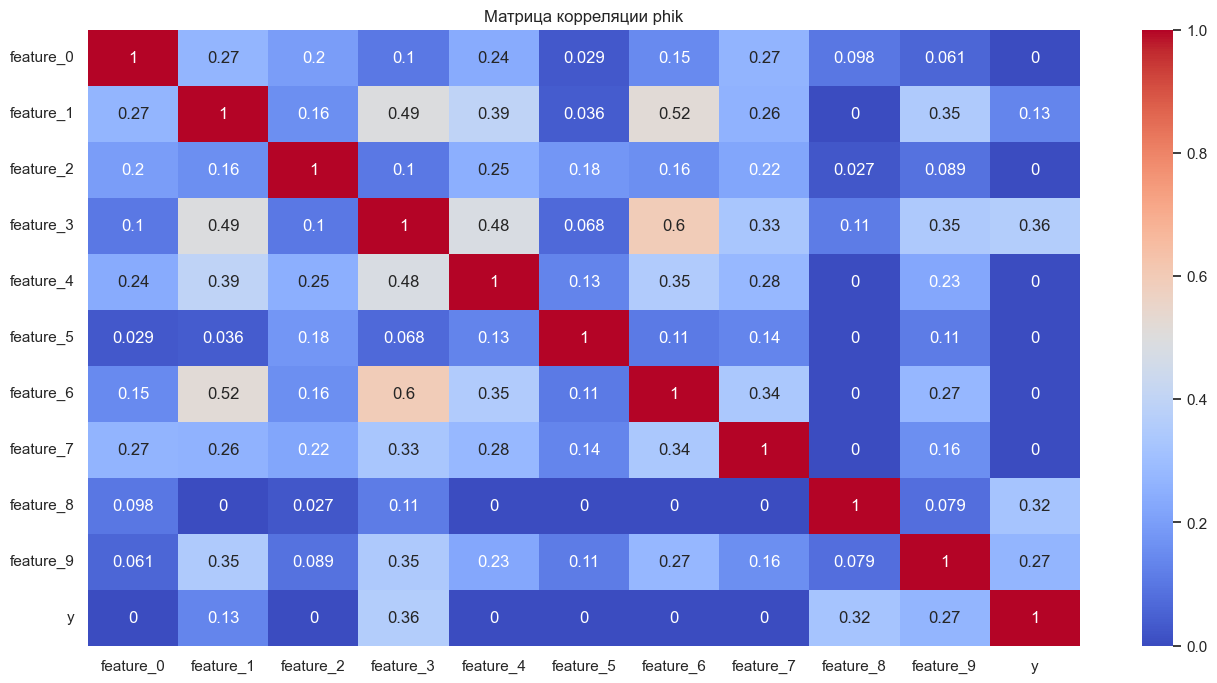

In [40]:
# Применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp)  
text_features = []

for embedding in embeddings:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features.append(reduced_embedding.numpy())
        
text_features = np.concatenate(text_features, axis=0)
text_features = pd.DataFrame(text_features, columns=[f'feature_{i}' for i in range(inp)])
text_features.to_csv('text_features_train', index=False)
text_features['y']=train['music_genre']

phik_overview = text_features[[col for col in text_features.columns]].phik_matrix()
# heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

In [35]:
text_features_train = pd.read_csv('text_features_train')

In [353]:
# Применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp) 
text_features_test = []

for embedding in embeddings_test:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features_test.append(reduced_embedding.numpy())
        
text_features_test = np.concatenate(text_features_test, axis=0)
text_features_test = pd.DataFrame(text_features_test, columns=[f'feature_{i}' for i in range(inp)])

text_features_test.to_csv('text_features_test', index=False)

In [36]:
text_features_test = pd.read_csv('text_features_test')

### Featuretools

In [37]:
y = train['music_genre']
train = train.drop(['music_genre', 'track_name'], axis=1)

In [39]:
X = train.copy()

In [45]:

# Список всех числовых признаков, которые вы хотите комбинировать
numeric_features = ['acousticness', 'danceability', 'energy', 'duration_ms', 'instrumentalness', 'liveness']

# Список математических операций, которые вы хотите применить
math_operations = ['add', 'subtract', 'multiply', 'divide']

from phik import phik_matrix
import pandas as pd

# Функция для создания новых признаков на основе математических операций
def create_math_features(data, features, operations, y, threshold=0.6):
    new_features = pd.DataFrame()
    
    for feature1 in features:
        for feature2 in features:
            if feature1 != feature2:
                for operation in operations:
                    if operation == 'add':
                        new_feature = data[feature1] + data[feature2]
                    elif operation == 'subtract':
                        new_feature = data[feature1] - data[feature2]
                    elif operation == 'multiply':
                        new_feature = data[feature1] * data[feature2]
                    elif operation == 'divide':
                        new_feature = data[feature1] / data[feature2]
                    
                    phik_value = phik_matrix(pd.concat([new_feature, y], axis=1)).iloc[0][1]
                    
                    if phik_value > threshold:
                        new_feature_name = f'{feature1}_{operation}_{feature2}'
                        new_features[new_feature_name] = new_feature
    
    return new_features

# Пример использования
new_features = create_math_features(X, numeric_features, math_operations, y, threshold=0.6)

# Добавляем новые признаки к исходным данным
X = pd.concat([X, new_features], axis=1)


interval columns not set, guessing: [0]


KeyError: 1

In [43]:
train['y']=y

phik_overview = train[[col for col in train.columns]].phik_matrix()


interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'acousticness_add_danceability', 'acousticness_subtract_danceability', 'acousticness_multiply_danceability', 'acousticness_divide_danceability', 'acousticness_add_energy', 'acousticness_subtract_energy', 'acousticness_multiply_energy', 'acousticness_divide_energy', 'acousticness_add_duration_ms', 'acousticness_subtract_duration_ms', 'acousticness_multiply_duration_ms', 'acousticness_divide_duration_ms', 'acousticness_add_instrumentalness', 'acousticness_subtract_instrumentalness', 'acousticness_multiply_instrumentalness', 'acousticness_divide_instrumentalness', 'acousticness_add_liveness', 'acousticness_subtract_liveness', 'acousticness_multiply_liveness', 'acousticness_divide_liveness', 'danceability_add_acousticness', 'danceability_subtract_acousticness', 'danceability_multiply_acousticness', 'danceability_divide_acousticnes

exception calling callback for <Future at 0x1737b8be0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/denismuhanov/miniconda3/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'fill_missing_tempo' on <module 'joblib.externals.loky.backend.popen_loky_posix' from '/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/popen_loky_posix.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_call

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Подготовка данных

In [263]:
# Разделение на признаки  и целевую переменную
X = train.drop(['track_name', 'music_genre'], axis=1).reset_index()
X =  pd.concat([X, txt_df], axis=1)
y = train['music_genre'].values

X_test = test.drop(['track_name'], axis=1)

In [265]:
# выделение числовые, текстовые и целевой признаки
categorical_cols = ['key', 'mode']

numerical_cols  = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']

In [266]:
X[categorical_cols] = X[categorical_cols].astype(str)

__Pipeline standart__

In [45]:
# создание трансформеров для числовых и категориальных признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# сборка всех трансформеров в один ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [46]:
# обучение preprocessor на всем обучающем наборе данных
preprocessor.fit(X)

# преобразование обучающих и тестовых данных с использованием обученного preprocessor
X_train_preprocessed = preprocessor.transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

# вывод размерности обработанных данных
print(f"Размерность X_train_preprocessed: {X_train_preprocessed.shape}")
print(f"Размерность X_test_preprocessed: {X_test_preprocessed.shape}")

Размерность X_train_preprocessed: (20394, 25)
Размерность X_test_preprocessed: (5099, 25)


__Pipeline log__

In [52]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
numerical_cols  = [ 'danceability', 'duration_ms', 'energy', 'loudness','tempo',
                       'acousticness','instrumentalness', 'liveness', 'speechiness']
# числовые признаки нужно логарифмировать
log_transform_cols = ['acousticness','instrumentalness', 'liveness', 'speechiness'] 

# Создайте трансформер для логарифмирования указанных признаков
log_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=False))
])

# Создайте трансформер для стандартизации остальных числовых признаков
numerical_transformer_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Создайте трансформер для категориальных признаков (оставляем их без изменений)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Создайте ColumnTransformer для всех признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Пример использования:
# X - ваш набор данных
X_transformed_log = preprocessor.fit_transform(X)


In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

numerical_cols  = [ 'danceability', 'duration_ms', 'energy', 'loudness','tempo',
                       'acousticness','instrumentalness', 'liveness', 'speechiness']
# числовые признаки нужно логарифмировать
log_transform_cols = ['acousticness','instrumentalness', 'liveness', 'speechiness'] 

# Создайте трансформер для логарифмирования указанных признаков
log_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=False))
])

# Создайте трансформер для стандартизации остальных числовых признаков
numerical_transformer_standardize = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Создайте ColumnTransformer для числовых признаков
numerical_preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_transform_cols),
        ('standardize', numerical_transformer_standardize, numerical_cols)
    ])

# Создайте трансформер для категориальных признаков (оставляем их без изменений)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Создайте ColumnTransformer для всех признаков, оставив категориальные признаки без изменений
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
remainder='passthrough')

# Пример использования:
# X - ваш набор данных
X_transformed = preprocessor.fit_transform(X)


In [271]:
# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  F1:', round(trial.value, 2))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
# создаем объект StratifiedKFold
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LogisticRegression

</div>

In [67]:
def objective(trial):
    # определение гиперпараметров для подбора
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    
    # экземпляр модели Logistic Regression
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=RANDOM_SEED,
        max_iter=1000,
        multi_class='multinomial'
    )
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_train_preprocessed, y):
        X_train_fold, y_train_fold = X_train_preprocessed[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_train_preprocessed[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [69]:
# подбор гиперпараметров
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective, n_trials=20)

[I 2023-10-09 17:22:41,680] A new study created in memory with name: no-name-89689127-061d-448f-b89c-0e1ab4743c6a
[I 2023-10-09 17:22:43,417] Trial 0 finished with value: 0.3804056688166689 and parameters: {'solver': 'newton-cg', 'C': 0.004690495596779716}. Best is trial 0 with value: 0.3804056688166689.
[I 2023-10-09 17:22:44,785] Trial 1 finished with value: 0.3832006421923975 and parameters: {'solver': 'lbfgs', 'C': 0.1457381900586257}. Best is trial 1 with value: 0.3832006421923975.
[I 2023-10-09 17:22:45,741] Trial 2 finished with value: 0.3809451537470982 and parameters: {'solver': 'sag', 'C': 0.028323607363098018}. Best is trial 1 with value: 0.3832006421923975.
[I 2023-10-09 17:22:46,506] Trial 3 finished with value: 0.34691541184045893 and parameters: {'solver': 'sag', 'C': 0.0001879795677524828}. Best is trial 1 with value: 0.3832006421923975.
[I 2023-10-09 17:22:48,479] Trial 4 finished with value: 0.3833476817699237 and parameters: {'solver': 'lbfgs', 'C': 1.396196983972482

In [70]:
# вывод результатов
trial_lr = study_lr.best_trial
best_mode_lr = trial_lr.user_attrs['best_model']
output_results(trial_lr)

Результаты подборы параметров:
  F1: 0.38
  Params: 
    solver: lbfgs
    C: 0.38098280229632536


>Успешно подобраны гиперпараметры для модели на основе LogisticRegression.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.38

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LGBMClassifier

</div>

In [154]:
def objective(trial):

    # пространство поиска гиперпараметров
    param_grid = {
            'verbosity': -1,
            'n_jobs': -1,
            'num_iterations': 1000,
            'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 505, step=100),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3)
        }

    model = LGBMClassifier(**param_grid)
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_train_preprocessed, y):
        X_train_fold, y_train_fold = X_train_preprocessed[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_train_preprocessed[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [155]:
# подбор гиперпараметров
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=20)

[I 2023-10-08 18:46:16,252] A new study created in memory with name: no-name-81781e70-7048-4a25-b051-f2f0398c58cc


[LightGBM] [Warning] feature_fraction is set=0.8500735533745667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500735533745667
[LightGBM] [Warning] feature_fraction is set=0.8500735533745667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500735533745667
[LightGBM] [Warning] feature_fraction is set=0.8500735533745667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500735533745667
[LightGBM] [Warning] feature_fraction is set=0.8500735533745667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500735533745667


[I 2023-10-08 18:46:46,761] Trial 0 finished with value: 0.43679523619851457 and parameters: {'feature_fraction': 0.8500735533745667, 'min_child_samples': 405, 'max_depth': 7, 'learning_rate': 0.030314975975494273}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.1225993031533345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1225993031533345
[LightGBM] [Warning] feature_fraction is set=0.1225993031533345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1225993031533345
[LightGBM] [Warning] feature_fraction is set=0.1225993031533345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1225993031533345
[LightGBM] [Warning] feature_fraction is set=0.1225993031533345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1225993031533345


[I 2023-10-08 18:47:12,081] Trial 1 finished with value: 0.38579960447324996 and parameters: {'feature_fraction': 0.1225993031533345, 'min_child_samples': 305, 'max_depth': 7, 'learning_rate': 0.20433012990501695}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.4956515879856358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4956515879856358
[LightGBM] [Warning] feature_fraction is set=0.4956515879856358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4956515879856358
[LightGBM] [Warning] feature_fraction is set=0.4956515879856358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4956515879856358
[LightGBM] [Warning] feature_fraction is set=0.4956515879856358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4956515879856358


[I 2023-10-08 18:47:37,691] Trial 2 finished with value: 0.4289498683231683 and parameters: {'feature_fraction': 0.4956515879856358, 'min_child_samples': 505, 'max_depth': 5, 'learning_rate': 0.07368945070144624}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.4613056463967096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4613056463967096
[LightGBM] [Warning] feature_fraction is set=0.4613056463967096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4613056463967096
[LightGBM] [Warning] feature_fraction is set=0.4613056463967096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4613056463967096
[LightGBM] [Warning] feature_fraction is set=0.4613056463967096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4613056463967096


[I 2023-10-08 18:48:13,492] Trial 3 finished with value: 0.4019324495429876 and parameters: {'feature_fraction': 0.4613056463967096, 'min_child_samples': 405, 'max_depth': 7, 'learning_rate': 0.21880690926498028}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.7551979035138687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7551979035138687
[LightGBM] [Warning] feature_fraction is set=0.7551979035138687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7551979035138687
[LightGBM] [Warning] feature_fraction is set=0.7551979035138687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7551979035138687
[LightGBM] [Warning] feature_fraction is set=0.7551979035138687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7551979035138687


[I 2023-10-08 18:48:55,311] Trial 4 finished with value: 0.4207119877735086 and parameters: {'feature_fraction': 0.7551979035138687, 'min_child_samples': 205, 'max_depth': 8, 'learning_rate': 0.047375764069946404}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.8258781800658291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258781800658291
[LightGBM] [Warning] feature_fraction is set=0.8258781800658291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258781800658291
[LightGBM] [Warning] feature_fraction is set=0.8258781800658291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258781800658291
[LightGBM] [Warning] feature_fraction is set=0.8258781800658291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258781800658291


[I 2023-10-08 18:49:33,187] Trial 5 finished with value: 0.4055606215451133 and parameters: {'feature_fraction': 0.8258781800658291, 'min_child_samples': 5, 'max_depth': 5, 'learning_rate': 0.28842952470954797}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.3000575730447959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000575730447959
[LightGBM] [Warning] feature_fraction is set=0.3000575730447959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000575730447959
[LightGBM] [Warning] feature_fraction is set=0.3000575730447959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000575730447959
[LightGBM] [Warning] feature_fraction is set=0.3000575730447959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000575730447959


[I 2023-10-08 18:49:50,813] Trial 6 finished with value: 0.3953613317052067 and parameters: {'feature_fraction': 0.3000575730447959, 'min_child_samples': 205, 'max_depth': 4, 'learning_rate': 0.23495312921850428}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.24358697065516863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24358697065516863
[LightGBM] [Warning] feature_fraction is set=0.24358697065516863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24358697065516863
[LightGBM] [Warning] feature_fraction is set=0.24358697065516863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24358697065516863
[LightGBM] [Warning] feature_fraction is set=0.24358697065516863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24358697065516863


[I 2023-10-08 18:50:08,934] Trial 7 finished with value: 0.4075708580925451 and parameters: {'feature_fraction': 0.24358697065516863, 'min_child_samples': 305, 'max_depth': 4, 'learning_rate': 0.17496868865135679}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.9838019809682196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838019809682196
[LightGBM] [Warning] feature_fraction is set=0.9838019809682196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838019809682196
[LightGBM] [Warning] feature_fraction is set=0.9838019809682196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838019809682196
[LightGBM] [Warning] feature_fraction is set=0.9838019809682196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838019809682196


[I 2023-10-08 18:50:58,936] Trial 8 finished with value: 0.42659598482798533 and parameters: {'feature_fraction': 0.9838019809682196, 'min_child_samples': 5, 'max_depth': 8, 'learning_rate': 0.040838028556951934}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.5292921620354039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292921620354039
[LightGBM] [Warning] feature_fraction is set=0.5292921620354039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292921620354039
[LightGBM] [Warning] feature_fraction is set=0.5292921620354039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292921620354039
[LightGBM] [Warning] feature_fraction is set=0.5292921620354039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292921620354039


[I 2023-10-08 18:51:34,226] Trial 9 finished with value: 0.400902393495413 and parameters: {'feature_fraction': 0.5292921620354039, 'min_child_samples': 405, 'max_depth': 6, 'learning_rate': 0.28732135569674716}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.011358185131768728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011358185131768728
[LightGBM] [Warning] feature_fraction is set=0.011358185131768728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011358185131768728
[LightGBM] [Warning] feature_fraction is set=0.011358185131768728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011358185131768728
[LightGBM] [Warning] feature_fraction is set=0.011358185131768728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011358185131768728


[I 2023-10-08 18:51:44,819] Trial 10 finished with value: 0.31097401116581375 and parameters: {'feature_fraction': 0.011358185131768728, 'min_child_samples': 105, 'max_depth': 3, 'learning_rate': 0.0022703796334765693}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.5836237413577074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5836237413577074
[LightGBM] [Warning] feature_fraction is set=0.5836237413577074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5836237413577074
[LightGBM] [Warning] feature_fraction is set=0.5836237413577074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5836237413577074
[LightGBM] [Warning] feature_fraction is set=0.5836237413577074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5836237413577074


[I 2023-10-08 18:52:16,590] Trial 11 finished with value: 0.41649534008891503 and parameters: {'feature_fraction': 0.5836237413577074, 'min_child_samples': 505, 'max_depth': 6, 'learning_rate': 0.10335772576020795}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.6806916822764087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806916822764087
[LightGBM] [Warning] feature_fraction is set=0.6806916822764087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806916822764087
[LightGBM] [Warning] feature_fraction is set=0.6806916822764087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806916822764087
[LightGBM] [Warning] feature_fraction is set=0.6806916822764087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806916822764087


[I 2023-10-08 18:52:39,987] Trial 12 finished with value: 0.4177208109560171 and parameters: {'feature_fraction': 0.6806916822764087, 'min_child_samples': 505, 'max_depth': 5, 'learning_rate': 0.10876866694678818}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.42602480620963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42602480620963
[LightGBM] [Warning] feature_fraction is set=0.42602480620963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42602480620963
[LightGBM] [Warning] feature_fraction is set=0.42602480620963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42602480620963
[LightGBM] [Warning] feature_fraction is set=0.42602480620963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42602480620963


[I 2023-10-08 18:53:10,292] Trial 13 finished with value: 0.4135532213448725 and parameters: {'feature_fraction': 0.42602480620963, 'min_child_samples': 405, 'max_depth': 7, 'learning_rate': 0.09774424879445764}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.9809891305313012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809891305313012
[LightGBM] [Warning] feature_fraction is set=0.9809891305313012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809891305313012
[LightGBM] [Warning] feature_fraction is set=0.9809891305313012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809891305313012
[LightGBM] [Warning] feature_fraction is set=0.9809891305313012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809891305313012


[I 2023-10-08 18:53:43,435] Trial 14 finished with value: 0.42674329369115294 and parameters: {'feature_fraction': 0.9809891305313012, 'min_child_samples': 505, 'max_depth': 6, 'learning_rate': 0.055982215975721665}. Best is trial 0 with value: 0.43679523619851457.


[LightGBM] [Warning] feature_fraction is set=0.6579178479608333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579178479608333
[LightGBM] [Warning] feature_fraction is set=0.6579178479608333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579178479608333
[LightGBM] [Warning] feature_fraction is set=0.6579178479608333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579178479608333
[LightGBM] [Warning] feature_fraction is set=0.6579178479608333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579178479608333


[I 2023-10-08 18:54:08,444] Trial 15 finished with value: 0.4463566749101413 and parameters: {'feature_fraction': 0.6579178479608333, 'min_child_samples': 405, 'max_depth': 4, 'learning_rate': 0.0045319029939716315}. Best is trial 15 with value: 0.4463566749101413.


[LightGBM] [Warning] feature_fraction is set=0.8543852254407505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543852254407505
[LightGBM] [Warning] feature_fraction is set=0.8543852254407505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543852254407505
[LightGBM] [Warning] feature_fraction is set=0.8543852254407505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543852254407505
[LightGBM] [Warning] feature_fraction is set=0.8543852254407505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543852254407505


[I 2023-10-08 18:54:27,977] Trial 16 finished with value: 0.42056535212444446 and parameters: {'feature_fraction': 0.8543852254407505, 'min_child_samples': 305, 'max_depth': 3, 'learning_rate': 0.001428140932704186}. Best is trial 15 with value: 0.4463566749101413.


[LightGBM] [Warning] feature_fraction is set=0.6641228226839008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641228226839008
[LightGBM] [Warning] feature_fraction is set=0.6641228226839008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641228226839008
[LightGBM] [Warning] feature_fraction is set=0.6641228226839008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641228226839008
[LightGBM] [Warning] feature_fraction is set=0.6641228226839008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641228226839008


[I 2023-10-08 18:54:47,238] Trial 17 finished with value: 0.4543980154109864 and parameters: {'feature_fraction': 0.6641228226839008, 'min_child_samples': 405, 'max_depth': 4, 'learning_rate': 0.025273878373699515}. Best is trial 17 with value: 0.4543980154109864.


[LightGBM] [Warning] feature_fraction is set=0.6249726774372202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6249726774372202
[LightGBM] [Warning] feature_fraction is set=0.6249726774372202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6249726774372202
[LightGBM] [Warning] feature_fraction is set=0.6249726774372202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6249726774372202
[LightGBM] [Warning] feature_fraction is set=0.6249726774372202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6249726774372202


[I 2023-10-08 18:55:11,087] Trial 18 finished with value: 0.4357164779192314 and parameters: {'feature_fraction': 0.6249726774372202, 'min_child_samples': 405, 'max_depth': 4, 'learning_rate': 0.0019217768052192238}. Best is trial 17 with value: 0.4543980154109864.


[LightGBM] [Warning] feature_fraction is set=0.679757707346048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679757707346048
[LightGBM] [Warning] feature_fraction is set=0.679757707346048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679757707346048
[LightGBM] [Warning] feature_fraction is set=0.679757707346048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679757707346048
[LightGBM] [Warning] feature_fraction is set=0.679757707346048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679757707346048


[I 2023-10-08 18:55:27,623] Trial 19 finished with value: 0.42218280671192154 and parameters: {'feature_fraction': 0.679757707346048, 'min_child_samples': 205, 'max_depth': 3, 'learning_rate': 0.13511026056092856}. Best is trial 17 with value: 0.4543980154109864.


In [157]:
# вывод результатов
trial_lgbm = study_lgbm.best_trial
best_mode_lgbm = trial_lgbm.user_attrs['best_model']
output_results(trial_lgbm)

Результаты подборы параметров:
  F1: 0.45
  Params: 
    feature_fraction: 0.6641228226839008
    min_child_samples: 405
    max_depth: 4
    learning_rate: 0.025273878373699515


>Успешно подобраны гиперпараметры для модели на основе LGBMClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.45

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  CatBoostClassifier

</div>

In [267]:
# Создаем объект StratifiedKFold
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

In [268]:
def objective(trial):
    # Пространство поиска гиперпараметров
    param_grid = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'random_seed': RANDOM_SEED,
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass'  
    }

    model = CatBoostClassifier(**param_grid)

    # Кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Разделение данных на обучающую и валидационную выборки
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Обучение модели
        train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=categorical_cols)
        val_pool = Pool(data=X_val_fold, label=y_val_fold, cat_features=categorical_cols)
        model.fit(train_pool, eval_set=val_pool)
        # Метрика качества
        preds = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, preds, average='micro')
        f1_scores.append(f1)

    score = np.average(f1_scores)

    # Сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)

    return score


In [269]:
# подбор гиперпараметров
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=20)

[I 2023-10-10 13:50:27,242] A new study created in memory with name: no-name-9da9a080-d5c3-4f90-bf04-12ef743bf570
[I 2023-10-10 13:53:17,380] Trial 0 finished with value: 0.4490534840522503 and parameters: {'learning_rate': 0.13742542133758692, 'depth': 8, 'l2_leaf_reg': 0.008282911919176959, 'border_count': 60}. Best is trial 0 with value: 0.4490534840522503.
[I 2023-10-10 13:54:47,116] Trial 1 finished with value: 0.46219440215163843 and parameters: {'learning_rate': 0.2952895113343188, 'depth': 4, 'l2_leaf_reg': 4.834211488112382, 'border_count': 83}. Best is trial 1 with value: 0.46219440215163843.
[I 2023-10-10 13:57:24,216] Trial 2 finished with value: 0.46547961965480505 and parameters: {'learning_rate': 0.03744293287374388, 'depth': 7, 'l2_leaf_reg': 0.6738273989209566, 'border_count': 139}. Best is trial 2 with value: 0.46547961965480505.
[I 2023-10-10 13:59:28,702] Trial 3 finished with value: 0.46959850703424105 and parameters: {'learning_rate': 0.07061819652561503, 'depth':

In [272]:
# вывод результатов
trial_cb = study_cb.best_trial
best_mode_cb = trial_cb.user_attrs['best_model']
output_results(trial_cb)

Результаты подборы параметров:
  F1: 0.47
  Params: 
    learning_rate: 0.05138809599775214
    depth: 5
    l2_leaf_reg: 0.0516558586129107
    border_count: 146


>Успешно подобраны гиперпараметры для модели на основе CatBoostClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.46

t = pd.read_csv('data/test.csv')
t['music_genre'] = pred
t = t[['instance_id', 'music_genre']]
t.to_csv('predict_1.csv', index=False)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Нейросеть PyTorch

</div>

In [76]:
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict


In [77]:
# Создаем объект StratifiedKFold
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

In [81]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

In [75]:
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
from sklearn.preprocessing import LabelEncoder

# Создайте экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Преобразуйте строковые метки в числовые значения
y_encoded = label_encoder.fit_transform(y)

In [249]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 10

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 170,  step=5)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 170,  step=5)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 170,  step=5)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 170,  step=5)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 5, 205,  step=25)
    
    # модель
    model_classifier = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 20,  step=10)

    # параметры подбора параметров модели
    skorch_classifier = NeuralNetClassifier(module=model_classifier,
                                            device='mps',
                                            batch_size=batch_size,
                                            verbose=100,
                                            optimizer=optim.Adam,
                                            max_epochs=500,
                                            lr=lr,
                                            criterion=nn.CrossEntropyLoss,  # Используйте CrossEntropyLoss для задачи классификации
                                            callbacks=[
                                                ('val_f1_micro', EpochScoring(scoring='f1_micro', lower_is_better=False, name='F1_micro')),
                                                ('estopper', EarlyStopping(lower_is_better=False, monitor='F1_micro', patience=patience))
                                            ])


    # Выполните кросс-валидацию
      
    y_pred = cross_val_predict(skorch_classifier, X_train_tensor, y_encoded, cv=cv, n_jobs=-1)

    # Рассчитайте F1-микро среди всех предсказаний
    f1_micro = f1_score(y_encoded, y_pred, average='micro')
    
    # Сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return f1_micro

In [250]:
# Подбор гиперпараметров
study_classifier = optuna.create_study(direction='maximize')
study_classifier.optimize(objective, n_trials=20)

[I 2023-10-09 15:32:59,347] A new study created in memory with name: no-name-b370cdd8-1f13-4ed6-8324-86b24a8193ae


  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1474       12.1405       0.1474        2.8463  0.9189
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1435       12.9622       0.1435        6.3665  0.9221
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1203        9.1328       0.1203        6.2416  0.9344
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1405       15.8598       0.1405        5.0152  0.9341
      2      0.1209        5.9130       0.1209        5.1858  0.4140
      2      0.1402        6.7498       0.1402        6.6306  0.4115
      2      0.0608        5.4584 

     28      0.2534        4.8754       0.2534        4.5262  0.4139
     28      0.2020        5.1307       0.2020        2.9654  0.4118
     28      0.1514        5.1208       0.1514        5.6488  0.4159
     29      0.2024        4.6920       0.2024        4.0957  0.4074
     29      0.1820        3.5998       0.1820        4.4671  0.4134
     29      0.2040        4.0658       0.2040        3.1845  0.4191
     30      0.1847        3.8920       0.1847        3.9004  0.4049
     30      0.1752        4.8265       0.1752        5.8061  0.4090
     30      0.1860        4.9878       0.1860        4.7733  0.4080
     31      0.1945        4.3166       0.1945        9.1907  0.4006
     31      0.1846        4.7475       0.1846        5.7194  0.3996
     32      0.2017        5.1846       0.2017        3.7847  0.3988
     32      0.1902        4.6862       0.1902        3.6869  0.4013
     33      0.1579        4.7943       0.1579        4.3141  0.3989
     33      0.1846        5.8473 

[I 2023-10-09 15:33:21,133] Trial 0 finished with value: 0.216534274786702 and parameters: {'module__drop_1': 0.5, 'module__drop_2': 0.2, 'module__drop_3': 0.5, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 25, 'module__hidden_size_2': 155, 'module__hidden_size_3': 110, 'module__hidden_size_4': 130, 'learning_rate': 0.29222143747249635, 'batch_size': 205, 'patience': 10}. Best is trial 0 with value: 0.216534274786702.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0869        2.3220       0.0869        2.3199  0.9274
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0876        2.3219       0.0876        2.3197  0.9897
      2      0.0902        2.3185       0.0902        2.3165  0.6154
      2      0.0932        2.3186       0.0932        2.3163  0.6222
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0892        2.3219       0.0892        2.3197  0.9683
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

     20      0.2575        2.1649       0.2575        2.1438  0.6233
     19      0.2491        2.1740       0.2491        2.1574  0.6016
     19      0.2458        2.1718       0.2458        2.1541  0.6050
     20      0.2560        2.1663       0.2560        2.1434  0.6644
     21      0.2654        2.1542       0.2654        2.1311  0.6300
     20      0.2583        2.1630       0.2583        2.1450  0.6187
     20      0.2513        2.1642       0.2513        2.1415  0.6248
     21      0.2625        2.1531       0.2625        2.1305  0.7103
     22      0.2709        2.1448       0.2709        2.1184  0.6361
     21      0.2641        2.1563       0.2641        2.1332  0.6331
     21      0.2601        2.1530       0.2601        2.1290  0.6184
     22      0.2694        2.1438       0.2694        2.1181  0.7085
     23      0.2788        2.1323       0.2788        2.1059  0.6076
     22      0.2684        2.1404       0.2684        2.1210  0.6004
     22      0.2699        2.1452 

     40      0.3128        1.9937       0.3128        1.9456  0.6336
     41      0.3219        1.9948       0.3219        1.9301  0.6176
     40      0.3138        1.9993       0.3138        1.9374  0.6210
     40      0.3163        1.9961       0.3163        1.9314  0.6096
     42      0.3242        1.9938       0.3242        1.9233  0.6159
     41      0.3161        1.9979       0.3161        1.9390  0.6447
     41      0.3145        1.9878       0.3145        1.9298  0.6237
     41      0.3199        1.9873       0.3199        1.9242  0.6069
     43      0.3301        1.9870       0.3301        1.9168  0.6179
     42      0.3184        1.9870       0.3184        1.9325  0.6259
     42      0.3138        1.9907       0.3138        1.9230  0.6256
     42      0.3216        1.9825       0.3216        1.9172  0.6151
     44      0.3297        1.9762       0.3297        1.9102  0.6155
     43      0.3171        1.9857       0.3171        1.9263  0.6369
     43      0.3171        1.9831 

     61      0.3357        1.9134       0.3357        1.8315  0.6388
     63      0.3418        1.9111       0.3418        1.8234  0.6167
     62      0.3321        1.9078       0.3321        1.8404  0.6183
     62      0.3386        1.9008       0.3386        1.8208  0.6317
     62      0.3370        1.9106       0.3370        1.8281  0.6384
     64      0.3412        1.9022       0.3412        1.8200  0.6181
     63      0.3338        1.9158       0.3338        1.8374  0.6184
     63      0.3395        1.9003       0.3395        1.8175  0.6157
     63      0.3374        1.9029       0.3374        1.8247  0.6339
     65      0.3425        1.9052       0.3425        1.8168  0.6169
     64      0.3325        1.9047       0.3325        1.8344  0.6124
     64      0.3408        1.9030       0.3408        1.8144  0.6223
     64      0.3361        1.9088       0.3361        1.8216  0.6317
     66      0.3422        1.8965       0.3422        1.8136  0.6146
     65      0.3325        1.9050 

     83      0.3478        1.8623       0.3478        1.7753  0.6129
     85      0.3526        1.8629       0.3526        1.7685  0.6114
     84      0.3459        1.8656       0.3459        1.7854  0.6356
     84      0.3539        1.8597       0.3539        1.7661  0.6075
     84      0.3482        1.8574       0.3482        1.7735  0.6111
     86      0.3523        1.8627       0.3523        1.7668  0.6092
     85      0.3462        1.8613       0.3462        1.7835  0.6374
     85      0.3533        1.8507       0.3533        1.7643  0.6251
     85      0.3478        1.8511       0.3478        1.7713  0.6165
     87      0.3516        1.8624       0.3516        1.7652  0.6301
     86      0.3446        1.8544       0.3446        1.7815  0.6288
     86      0.3523        1.8485       0.3523        1.7626  0.6281
     86      0.3495        1.8496       0.3495        1.7694  0.6324
     88      0.3529        1.8524       0.3529        1.7633  0.6206
     87      0.3455        1.8571 

    119      0.3573        1.8123       0.3573        1.7259  0.5993
    120      0.3582        1.8118       0.3582        1.7206  0.5893
    120      0.3576        1.8148       0.3576        1.7251  0.5823
    121      0.3588        1.8146       0.3588        1.7199  0.6023
    121      0.3580        1.8016       0.3580        1.7239  0.6039
    122      0.3601        1.8047       0.3601        1.7190  0.5980
    122      0.3589        1.8072       0.3589        1.7228  0.5879
    123      0.3598        1.8047       0.3598        1.7179  0.6083
    123      0.3589        1.8030       0.3589        1.7218  0.5925
    124      0.3595        1.8041       0.3595        1.7172  0.5765
    124      0.3589        1.8163       0.3589        1.7211  0.5923
    125      0.3582        1.8092       0.3582        1.7162  0.5943
    125      0.3583        1.8025       0.3583        1.7200  0.5838
    126      0.3595        1.8019       0.3595        1.7154  0.5690
    126      0.3589        1.8012 

[I 2023-10-09 15:34:45,200] Trial 1 finished with value: 0.36545062273217616 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.1, 'module__drop_4': 0.5, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 125, 'module__hidden_size_2': 125, 'module__hidden_size_3': 150, 'module__hidden_size_4': 35, 'learning_rate': 8.231129560272985e-06, 'batch_size': 130, 'patience': 10}. Best is trial 1 with value: 0.36545062273217616.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2334        2.2814       0.2334        2.2234  0.9919
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2324        2.2803       0.2324        2.2233  1.0064
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2428        2.2823       0.2428        2.2232  1.0116
      2      0.2537        2.1558       0.2537        2.0756  0.6366
      2      0.2399        2.1570       0.2399        2.0841  0.6295
      2      0.2464        2.1589       0.2464   

     18      0.3850        1.7484       0.3850        1.6791  0.6237
     20      0.3866        1.7435       0.3866        1.6666  0.6190
     20      0.3795        1.7417       0.3795        1.6770  0.6324
     20      0.3776        1.7364       0.3776        1.6916  0.6292
     19      0.3866        1.7432       0.3866        1.6748  0.6168
     21      0.3892        1.7414       0.3892        1.6646  0.6230
     21      0.3851        1.7298       0.3851        1.6740  0.6315
     21      0.3815        1.7413       0.3815        1.6891  0.6208
     20      0.3879        1.7409       0.3879        1.6700  0.6229
     22      0.3882        1.7335       0.3882        1.6605  0.6131
     22      0.3795        1.7254       0.3795        1.6859  0.6202
     22      0.3825        1.7277       0.3825        1.6698  0.6291
     21      0.3905        1.7327       0.3905        1.6665  0.6380
     23      0.3931        1.7298       0.3931        1.6572  0.6374
     23      0.3802        1.7294 

     40      0.4039        1.6833       0.4039        1.6249  0.6286
     42      0.4056        1.6792       0.4056        1.6179  0.6202
     42      0.3965        1.6812       0.3965        1.6484  0.6200
     42      0.4031        1.6819       0.4031        1.6307  0.6273
     41      0.4026        1.6935       0.4026        1.6250  0.6190
     43      0.4065        1.6847       0.4065        1.6181  0.6248
     43      0.3965        1.6816       0.3965        1.6479  0.6193
     43      0.4031        1.6739       0.4031        1.6296  0.6272
     42      0.4026        1.6737       0.4026        1.6226  0.6220
     44      0.4026        1.6909       0.4026        1.6160  0.6225
     44      0.3985        1.6739       0.3985        1.6468  0.6178
     44      0.4024        1.6777       0.4024        1.6279  0.6287
     43      0.4036        1.6786       0.4036        1.6215  0.6220
     45      0.4049        1.6850       0.4049        1.6167  0.6245
     45      0.3998        1.6814 

     66      0.4005        1.6529       0.4005        1.6304  0.6225
     65      0.4108        1.6465       0.4108        1.6026  0.6220
     66      0.4041        1.6404       0.4041        1.6089  0.6296
     67      0.4121        1.6573       0.4121        1.5950  0.6174
     67      0.4037        1.6471       0.4037        1.6290  0.6209
     66      0.4118        1.6421       0.4118        1.5998  0.6191
     67      0.4044        1.6491       0.4044        1.6076  0.6257
     68      0.4105        1.6527       0.4105        1.5956  0.6213
     68      0.4041        1.6460       0.4041        1.6272  0.6186
     67      0.4127        1.6467       0.4127        1.6003  0.6164
     68      0.4041        1.6543       0.4041        1.6076  0.6225
     69      0.4111        1.6457       0.4111        1.5951  0.6192
     69      0.4041        1.6523       0.4041        1.6273  0.6219
     68      0.4098        1.6452       0.4098        1.6005  0.6137
     69      0.4041        1.6335 

     96      0.4190        1.6151       0.4190        1.5866  0.5826
     98      0.4060        1.6254       0.4060        1.6170  0.5797
     97      0.4206        1.6206       0.4206        1.5863  0.5762
     99      0.4063        1.6186       0.4063        1.6155  0.5901
     98      0.4190        1.6215       0.4190        1.5855  0.5866
    100      0.4067        1.6262       0.4067        1.6153  0.5978
     99      0.4196        1.6189       0.4196        1.5854  0.5861
    101      0.4060        1.6214       0.4060        1.6161  0.5860
    100      0.4206        1.6259       0.4206        1.5852  0.5784
    102      0.4083        1.6297       0.4083        1.6135  0.5876
    101      0.4193        1.6142       0.4193        1.5848  0.5900
    103      0.4090        1.6221       0.4090        1.6143  0.5824
    102      0.4190        1.6192       0.4190        1.5840  0.5787
    104      0.4067        1.6182       0.4067        1.6135  0.5772
    103      0.4186        1.6198 

    194      0.4281        1.5775       0.4281        1.5651  0.5665
    195      0.4278        1.5777       0.4278        1.5652  0.5669
    196      0.4291        1.5737       0.4291        1.5648  0.5584
    197      0.4317        1.5799       0.4317        1.5646  0.5600
    198      0.4288        1.5831       0.4288        1.5645  0.5658
    199      0.4284        1.5754       0.4284        1.5654  0.5596
    200      0.4271        1.5727       0.4271        1.5646  0.5585
    201      0.4288        1.5732       0.4288        1.5645  0.5597
    202      0.4284        1.5759       0.4284        1.5632  0.5552
    203      0.4294        1.5745       0.4294        1.5630  0.5621
    204      0.4288        1.5766       0.4288        1.5627  0.5539
    205      0.4294        1.5775       0.4294        1.5639  0.5649
    206      0.4330        1.5778       0.4330        1.5646  0.5568
    207      0.4307        1.5730       0.4307        1.5639  0.5561
    208      0.4297        1.5703 

[I 2023-10-09 15:37:03,058] Trial 2 finished with value: 0.41968225948808474 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.2, 'module__drop_3': 0.4, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 85, 'module__hidden_size_2': 135, 'module__hidden_size_3': 120, 'module__hidden_size_4': 20, 'learning_rate': 0.00011787376067717473, 'batch_size': 130, 'patience': 20}. Best is trial 2 with value: 0.41968225948808474.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1157        2.3023       0.1157        2.2898  1.7560
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1187        2.3018       0.1187        2.2897  1.7928
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1222        2.3018       0.1222        2.2894  1.9724
      2      0.1771        2.2801       0.1771        2.2652  1.4241
      2      0.1821        2.2785       0.1821        2.2655  1.4291
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

     19      0.3497        1.7959       0.3497        1.7536  1.3992
     20      0.3526        1.7933       0.3526        1.7469  1.3895
     19      0.3534        1.7956       0.3534        1.7565  1.3908
     20      0.3455        1.7979       0.3455        1.7658  1.4116
     20      0.3533        1.7886       0.3533        1.7460  1.3847
     21      0.3565        1.7916       0.3565        1.7408  1.3939
     20      0.3560        1.7885       0.3560        1.7490  1.3941
     21      0.3485        1.7893       0.3485        1.7600  1.3954
     21      0.3552        1.7821       0.3552        1.7399  1.3983
     22      0.3588        1.7808       0.3588        1.7355  1.3978
     21      0.3560        1.7871       0.3560        1.7427  1.3969
     22      0.3511        1.7843       0.3511        1.7548  1.4018
     22      0.3565        1.7772       0.3565        1.7340  1.3948
     23      0.3592        1.7785       0.3592        1.7309  1.3967
     22      0.3576        1.7749 

     41      0.3622        1.7340       0.3622        1.7042  1.4086
     41      0.3663        1.7233       0.3663        1.6843  1.3905
     42      0.3742        1.7288       0.3742        1.6784  1.4054
     41      0.3717        1.7272       0.3717        1.6856  1.3985
     42      0.3616        1.7236       0.3616        1.7022  1.4096
     42      0.3663        1.7251       0.3663        1.6827  1.4080
     43      0.3758        1.7297       0.3758        1.6767  1.4010
     42      0.3723        1.7273       0.3723        1.6839  1.3996
     43      0.3632        1.7237       0.3632        1.7009  1.4068
     43      0.3667        1.7272       0.3667        1.6807  1.3940
     44      0.3755        1.7274       0.3755        1.6751  1.4127
     43      0.3740        1.7197       0.3740        1.6823  1.4009
     44      0.3622        1.7291       0.3622        1.6999  1.4187
     44      0.3673        1.7205       0.3673        1.6787  1.4161
     45      0.3771        1.7279 

     64      0.3938        1.7019       0.3938        1.6497  1.3916
     63      0.3818        1.7003       0.3818        1.6571  1.3870
     64      0.3714        1.6983       0.3714        1.6756  1.3985
     64      0.3837        1.6953       0.3837        1.6551  1.3905
     65      0.3931        1.6953       0.3931        1.6484  1.3993
     64      0.3828        1.6931       0.3828        1.6564  1.3788
     65      0.3717        1.7001       0.3717        1.6749  1.4035
     65      0.3856        1.6896       0.3856        1.6544  1.3855
     66      0.3925        1.6953       0.3925        1.6475  1.3945
     65      0.3818        1.7001       0.3818        1.6554  1.3893
     66      0.3727        1.7012       0.3727        1.6739  1.4006
     66      0.3850        1.6910       0.3850        1.6536  1.3823
     67      0.3931        1.6949       0.3931        1.6463  1.3886
     66      0.3841        1.6929       0.3841        1.6545  1.3842
     67      0.3743        1.6978 

     86      0.3929        1.6737       0.3929        1.6399  1.3868
     87      0.3928        1.6794       0.3928        1.6320  1.3951
     87      0.3802        1.6783       0.3802        1.6595  1.4018
     87      0.3895        1.6747       0.3895        1.6380  1.3902
     87      0.3926        1.6713       0.3926        1.6397  1.3970
     88      0.3915        1.6742       0.3915        1.6318  1.4023
     88      0.3789        1.6794       0.3789        1.6590  1.3949
     88      0.3889        1.6690       0.3889        1.6374  1.3828
     88      0.3920        1.6766       0.3920        1.6388  1.3827
     89      0.3925        1.6819       0.3925        1.6309  1.4015
     89      0.3795        1.6854       0.3795        1.6587  1.3977
     89      0.3899        1.6667       0.3899        1.6366  1.3840
     89      0.3907        1.6739       0.3907        1.6379  1.3894
     90      0.3931        1.6801       0.3931        1.6305  1.3882
     90      0.3812        1.6758 

    116      0.3929        1.6547       0.3929        1.6253  1.3518
    117      0.3935        1.6596       0.3935        1.6229  1.3689
    117      0.3822        1.6592       0.3822        1.6464  1.3702
    117      0.3936        1.6534       0.3936        1.6248  1.3516
    118      0.3922        1.6532       0.3922        1.6224  1.3468
    118      0.3808        1.6612       0.3808        1.6456  1.3655
    118      0.3939        1.6539       0.3939        1.6248  1.3594
    119      0.3925        1.6600       0.3925        1.6218  1.3541
    119      0.3805        1.6622       0.3805        1.6455  1.3506
    119      0.3939        1.6573       0.3939        1.6245  1.3540
    120      0.3935        1.6562       0.3935        1.6212  1.3648
    120      0.3812        1.6620       0.3812        1.6450  1.3551
    120      0.3946        1.6561       0.3946        1.6242  1.3556
    121      0.3928        1.6536       0.3928        1.6212  1.3461
    121      0.3815        1.6572 

    150      0.3938        1.6372       0.3938        1.6112  1.3858
    150      0.3861        1.6447       0.3861        1.6349  1.3927
    150      0.3978        1.6403       0.3978        1.6139  1.4006
    151      0.3951        1.6399       0.3951        1.6108  1.3529
    151      0.3877        1.6418       0.3877        1.6346  1.3684
    151      0.3972        1.6403       0.3972        1.6136  1.3573
    152      0.3954        1.6341       0.3954        1.6102  1.3738
    152      0.3887        1.6466       0.3887        1.6344  1.3553
    152      0.3978        1.6411       0.3978        1.6133  1.3531
    153      0.3954        1.6422       0.3954        1.6100  1.3470
    153      0.3890        1.6458       0.3890        1.6340  1.3557
    153      0.3992        1.6406       0.3992        1.6131  1.3592
    154      0.3958        1.6407       0.3958        1.6097  1.3557
    154      0.3900        1.6419       0.3900        1.6340  1.3660
    154      0.3982        1.6447 

    189      0.3942        1.6341       0.3942        1.6252  1.3354
    190      0.3990        1.6281       0.3990        1.5999  1.3356
    190      0.3942        1.6328       0.3942        1.6251  1.3352
    191      0.4007        1.6277       0.4007        1.5999  1.3153
    191      0.3949        1.6306       0.3949        1.6247  1.3304
    192      0.4003        1.6259       0.4003        1.5995  1.3212
    192      0.3939        1.6305       0.3939        1.6243  1.3368
    193      0.4016        1.6288       0.4016        1.5991  1.3419
    193      0.3949        1.6292       0.3949        1.6241  1.3388
    194      0.4020        1.6248       0.4020        1.5989  1.3261
    194      0.3965        1.6319       0.3965        1.6238  1.3338
    195      0.4016        1.6275       0.4016        1.5987  1.3361
    195      0.3959        1.6327       0.3959        1.6237  1.3324
    196      0.4033        1.6214       0.4033        1.5985  1.3144
    196      0.3949        1.6245 

    245      0.4024        1.6209       0.4024        1.6166  1.7347
    246      0.4018        1.6152       0.4018        1.6167  1.7122
    247      0.4018        1.6160       0.4018        1.6167  1.7190
    248      0.4005        1.6167       0.4005        1.6165  1.7115
    249      0.4011        1.6155       0.4011        1.6161  1.5472
    250      0.4027        1.6148       0.4027        1.6158  1.5985
    251      0.4014        1.6134       0.4014        1.6161  1.5327
    252      0.4014        1.6174       0.4014        1.6158  1.6935
    253      0.4021        1.6142       0.4021        1.6157  1.7325
    254      0.4024        1.6091       0.4024        1.6156  1.7240
    255      0.4024        1.6126       0.4024        1.6154  1.5250
    256      0.4024        1.6100       0.4024        1.6152  1.7226
    257      0.4024        1.6175       0.4024        1.6150  1.7058
    258      0.4037        1.6182       0.4037        1.6147  1.6989
    259      0.4027        1.6131 

[I 2023-10-09 15:44:11,088] Trial 3 finished with value: 0.40811022849857803 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.5, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 40, 'module__hidden_size_2': 30, 'module__hidden_size_3': 170, 'module__hidden_size_4': 140, 'learning_rate': 2.1831797106056164e-05, 'batch_size': 55, 'patience': 20}. Best is trial 2 with value: 0.41968225948808474.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3307        2.1467       0.3307        1.9180  1.4359
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3330        2.1435       0.3330        1.9214  1.4302
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3253        2.1462       0.3253        1.9292  1.5048
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     20      0.4121        1.5958       0.4121        1.5869  0.9874
     20      0.4082        1.5927       0.4082        1.5910  0.9910
     20      0.4090        1.5908       0.4090        1.6207  0.9825
     20      0.4044        1.5892       0.4044        1.6017  0.9901
     21      0.4111        1.5970       0.4111        1.5866  0.9872
     21      0.4092        1.5864       0.4092        1.5874  0.9786
     21      0.4067        1.5933       0.4067        1.6202  0.9800
     21      0.4044        1.5848       0.4044        1.5985  0.9919
     22      0.4111        1.5960       0.4111        1.5846  0.9944
     22      0.4078        1.5853       0.4078        1.5877  0.9821
     22      0.4093        1.5891       0.4093        1.6188  0.9951
     22      0.4054        1.5910       0.4054        1.5997  0.9902
     23      0.4134        1.5896       0.4134        1.5826  0.9854
     23      0.4098        1.5834       0.4098        1.5859  0.9922
     23      0.4090        1.5906 

     43      0.4122        1.5555       0.4122        1.6019  0.9879
     44      0.4206        1.5561       0.4206        1.5612  0.9879
     44      0.4258        1.5482       0.4258        1.5644  0.9865
     44      0.4207        1.5473       0.4207        1.5751  0.9891
     44      0.4096        1.5549       0.4096        1.6015  0.9947
     45      0.4196        1.5542       0.4196        1.5601  0.9855
     45      0.4258        1.5473       0.4258        1.5652  0.9827
     45      0.4214        1.5419       0.4214        1.5728  0.9870
     45      0.4135        1.5536       0.4135        1.5988  0.9863
     46      0.4206        1.5549       0.4206        1.5599  0.9866
     46      0.4281        1.5456       0.4281        1.5635  0.9817
     46      0.4191        1.5388       0.4191        1.5732  0.9856
     46      0.4119        1.5493       0.4119        1.6005  0.9957
     47      0.4199        1.5449       0.4199        1.5602  0.9789
     47      0.4281        1.5431 

     68      0.4148        1.5286       0.4148        1.5893  1.0056
     69      0.4353        1.5208       0.4353        1.5546  0.9907
     69      0.4212        1.5301       0.4212        1.5514  0.9980
     69      0.4253        1.5170       0.4253        1.5605  1.0056
     69      0.4155        1.5199       0.4155        1.5905  0.9966
     70      0.4327        1.5196       0.4327        1.5558  1.0024
     70      0.4232        1.5226       0.4232        1.5498  1.0025
     70      0.4250        1.5165       0.4250        1.5626  1.0112
     70      0.4155        1.5278       0.4155        1.5883  1.0082
     71      0.4333        1.5152       0.4333        1.5546  1.0089
     71      0.4216        1.5291       0.4216        1.5499  1.0135
     71      0.4230        1.5142       0.4230        1.5615  1.0043
     71      0.4139        1.5294       0.4139        1.5886  1.0071
     72      0.4350        1.5183       0.4350        1.5536  1.0192
     72      0.4232        1.5257 

    101      0.4194        1.5006       0.4194        1.5866  0.9539
    102      0.4369        1.4965       0.4369        1.5486  0.9655
    102      0.4292        1.4907       0.4292        1.5551  0.9592
    102      0.4194        1.5036       0.4194        1.5862  0.9601
    103      0.4356        1.4934       0.4356        1.5481  0.9668
    103      0.4296        1.4866       0.4296        1.5549  0.9613
    103      0.4220        1.5040       0.4220        1.5840  0.9587
    104      0.4353        1.4956       0.4353        1.5492  0.9753
    104      0.4289        1.4867       0.4289        1.5538  0.9712
    104      0.4191        1.4991       0.4191        1.5831  0.9637
    105      0.4359        1.4912       0.4359        1.5479  0.9611
    105      0.4269        1.4838       0.4269        1.5542  0.9690
    105      0.4188        1.4998       0.4188        1.5832  0.9695
    106      0.4350        1.4904       0.4350        1.5472  0.9687
    106      0.4269        1.4890 

[I 2023-10-09 15:46:34,193] Trial 4 finished with value: 0.43022457585564383 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.5, 'module__drop_3': 0.1, 'module__drop_4': 0.0, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 110, 'module__hidden_size_2': 125, 'module__hidden_size_3': 170, 'module__hidden_size_4': 150, 'learning_rate': 0.00014626250738892594, 'batch_size': 80, 'patience': 20}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3435        1.8415       0.3435        1.7657  1.2912
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3572        1.8617       0.3572        1.7424  1.3534
      2      0.3418        1.8040       0.3418        1.7553  0.9530
      2      0.3634        1.8238       0.3634        1.7569  0.9700
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3436        1.8566       0.3436        1.7689  1.4050
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

[I 2023-10-09 15:46:52,469] Trial 5 finished with value: 0.33191134647445325 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.4, 'module__drop_3': 0.5, 'module__drop_4': 0.0, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 115, 'module__hidden_size_2': 120, 'module__hidden_size_3': 135, 'module__hidden_size_4': 35, 'learning_rate': 0.015329161253059316, 'batch_size': 80, 'patience': 10}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3480        1.9608       0.3480        1.7346  0.8972
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3490        1.9625       0.3490        1.7549  0.9686
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3285        1.9670       0.3285        1.7534  0.9854
      2      0.3539        1.8192       0.3539        1.7017  0.5684
      2      0.3654        1.8265       0.3654        1.7030  0.5698
      2      0.3557        1.8256       0.3557   

     28      0.3902        1.7633       0.3902        1.6688  0.5216
     29      0.3869        1.7664       0.3869        1.6735  0.5230
     29      0.3902        1.7652       0.3902        1.6682  0.5206
     30      0.3967        1.7627       0.3967        1.6662  0.5068
     30      0.3879        1.7649       0.3879        1.6585  0.5142
     31      0.3843        1.7706       0.3843        1.6840  0.5252
     31      0.3876        1.7712       0.3876        1.6732  0.5093
     32      0.3814        1.7617       0.3814        1.6755  0.5159
     32      0.3899        1.7579       0.3899        1.6749  0.5292
     33      0.3876        1.7591       0.3876        1.6869  0.5095
     34      0.3895        1.7564       0.3895        1.6692  0.5069
     35      0.3882        1.7659       0.3882        1.6771  0.5187
     36      0.3912        1.7515       0.3912        1.6627  0.5360
     37      0.3873        1.7604       0.3873        1.6794  0.5343
     38      0.3987        1.7477 

[I 2023-10-09 15:47:19,210] Trial 6 finished with value: 0.3919289987251152 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.4, 'module__drop_3': 0.4, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 25, 'module__hidden_size_2': 130, 'module__hidden_size_3': 65, 'module__hidden_size_4': 45, 'learning_rate': 0.010316633727831632, 'batch_size': 155, 'patience': 10}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1638        2.2412       0.1638        2.0228  0.8191
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1988        2.3243       0.1988        2.0733  0.8796
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2693        2.2144       0.2693        1.9974  0.9308
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

[I 2023-10-09 15:47:26,865] Trial 7 finished with value: 0.19392958713347067 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.5, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 140, 'module__hidden_size_2': 100, 'module__hidden_size_3': 85, 'module__hidden_size_4': 20, 'learning_rate': 0.09122054904351566, 'batch_size': 205, 'patience': 10}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1758        2.2982       0.1758        2.2878  0.9293
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1752        2.2981       0.1752        2.2878  0.9537
      2      0.2700        2.2802       0.2700        2.2634  0.5639
      2      0.2654        2.2795       0.2654        2.2630  0.5672
      3      0.3008        2.2496       0.3008        2.2186  0.5420
      3      0.3095        2.2496       0.3095        2.2188  0.5420
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1814        2.2985       0.18

     19      0.3616        1.7612       0.3616        1.7130  0.5822
     21      0.3706        1.7501       0.3706        1.6867  0.5918
     21      0.3701        1.7554       0.3701        1.6876  0.5869
     19      0.3722        1.7625       0.3722        1.6941  0.5808
     20      0.3616        1.7557       0.3616        1.7100  0.5801
     22      0.3712        1.7409       0.3712        1.6829  0.5812
     22      0.3714        1.7470       0.3714        1.6848  0.5747
     20      0.3725        1.7557       0.3725        1.6897  0.5793
     21      0.3635        1.7519       0.3635        1.7063  0.5778
     23      0.3722        1.7389       0.3722        1.6807  0.5831
     23      0.3733        1.7434       0.3733        1.6819  0.5939
     21      0.3742        1.7497       0.3742        1.6858  0.5728
     22      0.3681        1.7496       0.3681        1.7033  0.5845
     24      0.3748        1.7385       0.3748        1.6772  0.5829
     24      0.3737        1.7428 

     40      0.3886        1.7081       0.3886        1.6425  0.5643
     41      0.3822        1.7026       0.3822        1.6663  0.5593
     43      0.3908        1.6934       0.3908        1.6421  0.5691
     43      0.3884        1.6910       0.3884        1.6437  0.5675
     41      0.3882        1.7085       0.3882        1.6410  0.5602
     42      0.3828        1.7067       0.3828        1.6655  0.5615
     44      0.3915        1.6930       0.3915        1.6414  0.5563
     44      0.3877        1.6923       0.3877        1.6422  0.5528
     42      0.3895        1.7058       0.3895        1.6395  0.5583
     43      0.3822        1.7007       0.3822        1.6641  0.5671
     45      0.3922        1.6920       0.3922        1.6400  0.5706
     45      0.3880        1.7012       0.3880        1.6404  0.5730
     43      0.3905        1.7025       0.3905        1.6386  0.5656
     44      0.3822        1.6958       0.3822        1.6626  0.5659
     46      0.3915        1.6923 

     64      0.3974        1.6743       0.3974        1.6170  0.5491
     65      0.3877        1.6722       0.3877        1.6447  0.5606
     67      0.3938        1.6666       0.3938        1.6188  0.5642
     67      0.3969        1.6713       0.3969        1.6211  0.5977
     65      0.3987        1.6770       0.3987        1.6166  0.6495
     66      0.3890        1.6694       0.3890        1.6437  0.6629
     68      0.3964        1.6679       0.3964        1.6189  0.6378
     68      0.3956        1.6644       0.3956        1.6207  0.6100
     66      0.3980        1.6755       0.3980        1.6159  0.5725
     67      0.3874        1.6704       0.3874        1.6432  0.5467
     69      0.3958        1.6720       0.3958        1.6177  0.5422
     69      0.3962        1.6539       0.3962        1.6192  0.5485
     67      0.3984        1.6743       0.3984        1.6149  0.5477
     68      0.3871        1.6644       0.3871        1.6428  0.5279
     70      0.3954        1.6652 

     97      0.4072        1.6493       0.4072        1.5989  0.5065
     98      0.3946        1.6481       0.3946        1.6291  0.5170
     98      0.4059        1.6474       0.4059        1.5983  0.5300
     99      0.3920        1.6442       0.3920        1.6290  0.4898
     99      0.4062        1.6470       0.4062        1.5982  0.5005
    100      0.3933        1.6463       0.3933        1.6282  0.4923
    100      0.4059        1.6527       0.4059        1.5978  0.4979
    101      0.3956        1.6517       0.3956        1.6274  0.4905
    101      0.4072        1.6504       0.4072        1.5969  0.5018
    102      0.3926        1.6449       0.3926        1.6273  0.4975
    102      0.4062        1.6469       0.4062        1.5967  0.4914
    103      0.3923        1.6519       0.3923        1.6273  0.4983
    103      0.4052        1.6479       0.4052        1.5960  0.4846
    104      0.3910        1.6424       0.3910        1.6269  0.5008
    104      0.4088        1.6467 

    157      0.4001        1.6215       0.4001        1.6142  0.4557
    158      0.4008        1.6217       0.4008        1.6138  0.4526
    159      0.3998        1.6140       0.3998        1.6138  0.4679
    160      0.4008        1.6149       0.4008        1.6137  0.4473
    161      0.4001        1.6174       0.4001        1.6131  0.4672
    162      0.3992        1.6195       0.3992        1.6131  0.4414
    163      0.4001        1.6138       0.4001        1.6131  0.4506
    164      0.3998        1.6145       0.3998        1.6129  0.4454
    165      0.4021        1.6147       0.4021        1.6127  0.4557
    166      0.4001        1.6141       0.4001        1.6123  0.4497
    167      0.4005        1.6127       0.4005        1.6126  0.4563
    168      0.4031        1.6092       0.4031        1.6121  0.4419


[I 2023-10-09 15:48:59,584] Trial 8 finished with value: 0.4124742571344513 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.5, 'module__drop_4': 0.4, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 80, 'module__hidden_size_2': 130, 'module__hidden_size_3': 145, 'module__hidden_size_4': 110, 'learning_rate': 5.406062642646808e-05, 'batch_size': 155, 'patience': 20}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1284        2.2907       0.1284        2.2854  1.8916
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1268        2.2910       0.1268        2.2856  1.9239
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1268        2.2921       0.1268        2.2856  2.0551
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     19      0.3079        2.0581       0.3079        2.0287  1.4515
     19      0.3141        2.0591       0.3141        2.0289  1.4633
     20      0.3109        2.0464       0.3109        2.0201  1.4619
     20      0.3085        2.0446       0.3085        2.0106  1.4670
     20      0.3066        2.0487       0.3066        2.0143  1.4588
     20      0.3105        2.0457       0.3105        2.0142  1.4783
     21      0.3109        2.0339       0.3109        2.0069  1.4358
     21      0.3085        2.0304       0.3085        1.9969  1.4569
     21      0.3057        2.0341       0.3057        2.0009  1.4487
     21      0.3088        2.0345       0.3088        2.0006  1.4579
     22      0.3086        2.0191       0.3086        1.9947  1.4337
     22      0.3085        2.0228       0.3085        1.9844  1.4487
     22      0.3060        2.0210       0.3060        1.9884  1.4334
     22      0.3098        2.0191       0.3098        1.9879  1.4561
     23      0.3073        2.0117 

[I 2023-10-09 15:49:40,885] Trial 9 finished with value: 0.3099441012062371 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 45, 'module__hidden_size_2': 110, 'module__hidden_size_3': 165, 'module__hidden_size_4': 50, 'learning_rate': 6.973864617353241e-06, 'batch_size': 55, 'patience': 10}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3889        1.7467       0.3889        1.6420  14.2779
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3837        1.7387       0.3837        1.6563  14.4703
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3844        1.7500       0.3844        1.6693  15.2850
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  ---------

     20      0.4096        1.4506       0.4096        1.6196  14.1191
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
     21      0.4176        1.4494       0.4176        1.5807  13.9583
     21      0.4222        1.4427       0.4222        1.5831  13.8379
     21      0.4240        1.4377       0.4240        1.5872  14.2631
     21      0.4171        1.4488       0.4171        1.6167  14.3139
     22      0.4180        1.4463       0.4180        1.5857  14.0673
     22      0.4225        1.4393       0.4225        1.5850  13.9857
     22      0.4106        1.4340       0.4106        1.5911  14.1850
     22      0.4148        1.4433       0.4148        1.6287  14.1694
     23      0.4219        1.4380       0.4219        1.5847  13.7631
     23      0.4186        1.4434       0.4186        1.5846  13.9176
     23      0.4184        1.4248     

[I 2023-10-09 16:03:33,062] Trial 10 finished with value: 0.4174757281553398 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.0, 'module__drop_3': 0.0, 'module__drop_4': 0.0, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 160, 'module__hidden_size_2': 60, 'module__hidden_size_3': 10, 'module__hidden_size_4': 160, 'learning_rate': 0.0006734750364183278, 'batch_size': 5, 'patience': 20}. Best is trial 4 with value: 0.43022457585564383.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3416        2.0742       0.3416        1.7965  1.4650
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3432        2.0736       0.3432        1.8048  1.5309
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3497        2.0716       0.3497        1.7873  1.6250
      2      0.3599        1.7638       0.3599        1.6984  0.7870
      2      0.3589        1.7564       0.3589        1.7109  0.8062
      2      0.3693        1.7632       0.3693   

     21      0.4206        1.5815       0.4206        1.5664  0.7944
     21      0.3985        1.5883       0.3985        1.6057  0.7966
     20      0.4137        1.5861       0.4137        1.5773  0.7850
     21      0.4122        1.5803       0.4122        1.5836  0.7940
     22      0.4170        1.5812       0.4170        1.5646  0.8036
     22      0.4027        1.5769       0.4027        1.6050  0.8032
     21      0.4147        1.5799       0.4147        1.5777  0.7872
     22      0.4112        1.5699       0.4112        1.5861  0.8078
     23      0.4199        1.5794       0.4199        1.5637  0.8006
     23      0.4027        1.5755       0.4027        1.6034  0.7964
     22      0.4176        1.5724       0.4176        1.5741  0.7947
     23      0.4122        1.5701       0.4122        1.5815  0.8084
     24      0.4225        1.5761       0.4225        1.5635  0.7839
     24      0.4018        1.5747       0.4018        1.6033  0.7819
     23      0.4212        1.5776 

     44      0.4278        1.5358       0.4278        1.5592  0.7863
     45      0.4235        1.5448       0.4235        1.5506  0.8057
     45      0.4112        1.5408       0.4112        1.5940  0.8107
     45      0.4227        1.5335       0.4227        1.5670  0.8109
     45      0.4320        1.5326       0.4320        1.5607  0.7836
     46      0.4252        1.5417       0.4252        1.5481  0.7972
     46      0.4103        1.5374       0.4103        1.5949  0.7970
     46      0.4220        1.5306       0.4220        1.5672  0.8150
     46      0.4284        1.5382       0.4284        1.5598  0.8028
     47      0.4242        1.5385       0.4242        1.5487  0.8218
     47      0.4148        1.5341       0.4148        1.5928  0.8374
     47      0.4204        1.5297       0.4204        1.5664  0.8260
     47      0.4294        1.5332       0.4294        1.5586  0.7878
     48      0.4245        1.5398       0.4245        1.5477  0.7952
     48      0.4132        1.5364 

     71      0.4288        1.5123       0.4288        1.5419  0.8006
     71      0.4145        1.5099       0.4145        1.5886  0.8000
     71      0.4292        1.5061       0.4292        1.5567  0.7815
     71      0.4301        1.5126       0.4301        1.5522  0.7779
     72      0.4275        1.5082       0.4275        1.5404  0.7858
     72      0.4171        1.5061       0.4171        1.5889  0.7873
     72      0.4237        1.5025       0.4237        1.5580  0.7758
     72      0.4284        1.5043       0.4284        1.5502  0.7687
     73      0.4271        1.5122       0.4271        1.5415  0.7830
     73      0.4155        1.5105       0.4155        1.5858  0.7819
     73      0.4263        1.5018       0.4263        1.5562  0.7815
     73      0.4317        1.5036       0.4317        1.5501  0.7670
     74      0.4271        1.5168       0.4271        1.5406  0.7832
     74      0.4135        1.5013       0.4135        1.5869  0.7859
     74      0.4289        1.4970 

    108      0.4129        1.4825       0.4129        1.5840  0.7476
    109      0.4333        1.4832       0.4333        1.5354  0.7610
    109      0.4106        1.4776       0.4106        1.5851  0.7521
    110      0.4343        1.4834       0.4343        1.5359  0.7394
    110      0.4126        1.4809       0.4126        1.5837  0.7387
    111      0.4330        1.4831       0.4330        1.5335  0.7571
    111      0.4126        1.4784       0.4126        1.5832  0.7682
    112      0.4317        1.4806       0.4317        1.5350  0.7537
    112      0.4116        1.4793       0.4116        1.5834  0.7569
    113      0.4310        1.4839       0.4310        1.5381  0.7595
    113      0.4119        1.4736       0.4119        1.5827  0.7538
    114      0.4310        1.4818       0.4310        1.5372  0.7508
    115      0.4340        1.4805       0.4340        1.5365  0.7453


[I 2023-10-09 16:05:06,763] Trial 11 finished with value: 0.4336569579288026 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 80, 'module__hidden_size_2': 165, 'module__hidden_size_3': 110, 'module__hidden_size_4': 90, 'learning_rate': 0.00034815171429454896, 'batch_size': 105, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0624        2.3031       0.0624        2.3027  1.4800
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0641        2.3029       0.0641        2.3029  1.4865
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0654        2.3034       0.0654        2.3027  1.4974
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0634        2.3031       0.0634        2.3027  1.5142
      2      0.0634        2.3026       0.0634        2.3023  1.0141
      2      0.0647        2.3027      

     20      0.0912        2.2959       0.0912        2.2953  0.9854
     20      0.0860        2.2962       0.0860        2.2955  0.9695
     20      0.0846        2.2961       0.0846        2.2956  0.9845
     20      0.0879        2.2960       0.0879        2.2952  0.9807
     21      0.0919        2.2954       0.0919        2.2949  0.9939
     21      0.0899        2.2958       0.0899        2.2951  0.9801
     21      0.0876        2.2959       0.0876        2.2951  0.9707
     21      0.0915        2.2955       0.0915        2.2948  0.9823
     22      0.0948        2.2950       0.0948        2.2945  1.0011
     22      0.0919        2.2952       0.0919        2.2947  0.9879
     22      0.0892        2.2952       0.0892        2.2947  0.9908
     22      0.0918        2.2951       0.0918        2.2944  0.9895
     23      0.0968        2.2950       0.0968        2.2940  0.9903
     23      0.0928        2.2948       0.0928        2.2942  0.9769
     23      0.0912        2.2948 

     40      0.1543        2.2876       0.1543        2.2861  0.9772
     40      0.1484        2.2871       0.1484        2.2865  0.9680
     40      0.1480        2.2872       0.1480        2.2864  0.9633
     40      0.1480        2.2874       0.1480        2.2859  0.9735
     41      0.1553        2.2868       0.1553        2.2856  0.9777
     41      0.1510        2.2870       0.1510        2.2860  0.9549
     41      0.1520        2.2870       0.1520        2.2859  0.9684
     41      0.1497        2.2870       0.1497        2.2854  0.9548
     42      0.1576        2.2863       0.1576        2.2851  0.9731
     42      0.1533        2.2868       0.1533        2.2855  0.9573
     42      0.1552        2.2867       0.1552        2.2854  0.9602
     42      0.1500        2.2863       0.1500        2.2849  0.9662
     43      0.1615        2.2858       0.1615        2.2846  0.9843
     43      0.1566        2.2856       0.1566        2.2850  0.9790
     43      0.1582        2.2861 

     60      0.1834        2.2770       0.1834        2.2749  1.0031
     60      0.1869        2.2769       0.1869        2.2751  0.9760
     60      0.1856        2.2767       0.1856        2.2746  0.9890
     60      0.1821        2.2767       0.1821        2.2756  0.9865
     61      0.1844        2.2758       0.1844        2.2743  0.9902
     61      0.1886        2.2762       0.1886        2.2745  0.9732
     61      0.1866        2.2761       0.1866        2.2739  0.9774
     61      0.1844        2.2766       0.1844        2.2750  0.9806
     62      0.1873        2.2758       0.1873        2.2736  0.9904
     62      0.1902        2.2750       0.1902        2.2738  0.9782
     62      0.1882        2.2758       0.1882        2.2733  0.9707
     62      0.1873        2.2757       0.1873        2.2743  0.9750
     63      0.1899        2.2750       0.1899        2.2730  0.9890
     63      0.1905        2.2747       0.1905        2.2731  0.9727
     63      0.1908        2.2756 

     80      0.2219        2.2634       0.2219        2.2607  0.9666
     80      0.2216        2.2636       0.2216        2.2616  0.9698
     80      0.2261        2.2639       0.2261        2.2601  0.9698
     80      0.2256        2.2632       0.2256        2.2606  0.9853
     81      0.2207        2.2630       0.2207        2.2609  0.9852
     81      0.2242        2.2628       0.2242        2.2599  0.9875
     81      0.2278        2.2627       0.2278        2.2593  0.9841
     81      0.2256        2.2627       0.2256        2.2598  0.9985
     82      0.2210        2.2620       0.2210        2.2601  0.9855
     82      0.2255        2.2622       0.2255        2.2591  0.9966
     82      0.2288        2.2613       0.2288        2.2584  0.9912
     82      0.2262        2.2621       0.2262        2.2590  1.0005
     83      0.2236        2.2611       0.2236        2.2593  0.9866
     83      0.2268        2.2613       0.2268        2.2583  0.9840
     83      0.2297        2.2614 

    101      0.2379        2.2461       0.2379        2.2422  0.9834
    101      0.2377        2.2461       0.2377        2.2437  0.9891
    101      0.2467        2.2462       0.2467        2.2413  0.9936
    101      0.2377        2.2458       0.2377        2.2421  1.0068
    102      0.2382        2.2455       0.2382        2.2412  0.9951
    102      0.2380        2.2458       0.2380        2.2427  0.9977
    102      0.2477        2.2454       0.2477        2.2403  0.9896
    102      0.2380        2.2458       0.2380        2.2412  0.9975
    103      0.2382        2.2444       0.2382        2.2402  1.0197
    103      0.2386        2.2439       0.2386        2.2418  1.0033
    103      0.2487        2.2439       0.2487        2.2393  1.0114
    103      0.2386        2.2446       0.2386        2.2402  1.0324
    104      0.2392        2.2430       0.2392        2.2392  0.9818
    104      0.2403        2.2433       0.2403        2.2408  0.9804
    104      0.2500        2.2430 

    122      0.2498        2.2249       0.2498        2.2215  0.9627
    122      0.2490        2.2246       0.2490        2.2195  0.9749
    122      0.2647        2.2244       0.2647        2.2183  0.9755
    122      0.2455        2.2255       0.2455        2.2196  0.9782
    123      0.2511        2.2231       0.2511        2.2203  0.9719
    123      0.2487        2.2233       0.2487        2.2183  0.9784
    123      0.2660        2.2239       0.2660        2.2171  0.9837
    123      0.2458        2.2242       0.2458        2.2185  1.0087
    124      0.2524        2.2229       0.2524        2.2191  0.9913
    124      0.2477        2.2228       0.2477        2.2171  0.9932
    124      0.2670        2.2240       0.2670        2.2159  0.9953
    124      0.2462        2.2244       0.2462        2.2173  1.0172
    125      0.2527        2.2222       0.2527        2.2180  1.0148
    125      0.2487        2.2211       0.2487        2.2159  1.0021
    125      0.2667        2.2212 

    143      0.2712        2.2004       0.2712        2.1922  0.9876
    143      0.2586        2.2029       0.2586        2.1940  0.9758
    144      0.2609        2.2006       0.2609        2.1949  0.9813
    144      0.2588        2.1991       0.2588        2.1923  0.9634
    144      0.2722        2.1998       0.2722        2.1909  0.9653
    144      0.2586        2.2016       0.2586        2.1928  0.9782
    145      0.2605        2.1996       0.2605        2.1937  0.9615
    145      0.2601        2.1981       0.2601        2.1910  0.9678
    145      0.2742        2.1998       0.2742        2.1896  0.9670
    145      0.2583        2.1986       0.2583        2.1915  0.9864
    146      0.2605        2.1986       0.2605        2.1925  0.9778
    146      0.2605        2.1963       0.2605        2.1897  0.9825
    146      0.2735        2.1986       0.2735        2.1883  0.9960
    146      0.2586        2.1965       0.2586        2.1902  0.9876
    147      0.2602        2.1962 

    167      0.2746        2.1720       0.2746        2.1662  0.9982
    167      0.2641        2.1707       0.2641        2.1629  0.9999
    166      0.2654        2.1760       0.2654        2.1652  1.0022
    167      0.2801        2.1737       0.2801        2.1613  0.9841
    168      0.2730        2.1706       0.2730        2.1650  0.9832
    168      0.2650        2.1702       0.2650        2.1616  0.9763
    167      0.2677        2.1743       0.2677        2.1639  0.9848
    168      0.2820        2.1709       0.2820        2.1600  0.9750
    169      0.2746        2.1683       0.2746        2.1638  0.9705
    169      0.2670        2.1682       0.2670        2.1603  0.9614
    168      0.2674        2.1712       0.2674        2.1627  0.9841
    169      0.2824        2.1692       0.2824        2.1587  0.9747
    170      0.2743        2.1683       0.2743        2.1625  0.9676
    170      0.2686        2.1654       0.2686        2.1591  0.9638
    169      0.2684        2.1703 

    188      0.2905        2.1469       0.2905        2.1350  0.9773
    187      0.2864        2.1485       0.2864        2.1397  0.9899
    189      0.2807        2.1446       0.2807        2.1357  0.9722
    189      0.2867        2.1464       0.2867        2.1397  0.9670
    189      0.2925        2.1453       0.2925        2.1337  0.9752
    188      0.2880        2.1471       0.2880        2.1385  0.9902
    190      0.2817        2.1444       0.2817        2.1345  0.9655
    190      0.2877        2.1459       0.2877        2.1385  0.9628
    190      0.2918        2.1452       0.2918        2.1325  0.9625
    189      0.2890        2.1473       0.2890        2.1373  0.9724
    191      0.2824        2.1426       0.2824        2.1333  0.9983
    191      0.2883        2.1426       0.2883        2.1373  0.9882
    191      0.2925        2.1447       0.2925        2.1313  0.9983
    190      0.2887        2.1472       0.2887        2.1362  1.0133
    192      0.2873        2.1418 

    211      0.2967        2.1221       0.2967        2.1071  0.9614
    210      0.2860        2.1244       0.2860        2.1129  0.9885
    212      0.2864        2.1201       0.2864        2.1129  0.9630
    212      0.2876        2.1169       0.2876        2.1084  0.9574
    212      0.2971        2.1206       0.2971        2.1059  0.9558
    213      0.2864        2.1181       0.2864        2.1117  0.9552
    213      0.2879        2.1166       0.2879        2.1073  0.9540
    213      0.2977        2.1186       0.2977        2.1047  0.9504
    214      0.2879        2.1161       0.2879        2.1061  0.9224
    214      0.2857        2.1179       0.2857        2.1106  0.9363
    214      0.2980        2.1185       0.2980        2.1035  0.9293
    215      0.2876        2.1151       0.2876        2.1049  0.9433
    215      0.2864        2.1168       0.2864        2.1094  0.9463
    215      0.2961        2.1185       0.2961        2.1023  0.9520
    216      0.2886        2.1147 

[I 2023-10-09 16:09:02,612] Trial 12 finished with value: 0.29096793174463076 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 70, 'module__hidden_size_2': 170, 'module__hidden_size_3': 45, 'module__hidden_size_4': 80, 'learning_rate': 1.0092954434566267e-06, 'batch_size': 80, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3938        1.7805       0.3938        1.6413  16.8306
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3792        1.7851       0.3792        1.6827  17.0866
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3765        1.7812       0.3765        1.6766  17.2213
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  ---------

     21      0.4239        1.5205       0.4239        1.5724  15.6327
     21      0.4240        1.5055       0.4240        1.5815  15.6802
     21      0.4171        1.5158       0.4171        1.6087  15.7957
     21      0.4261        1.5165       0.4261        1.5744  15.9491
     22      0.4252        1.5157       0.4252        1.5735  15.8433
     22      0.4224        1.5045       0.4224        1.5795  15.8035
     22      0.4155        1.5081       0.4155        1.6032  15.9281
     22      0.4232        1.5183       0.4232        1.5669  16.1156
     23      0.4222        1.5199       0.4222        1.5770  15.8060
     23      0.4227        1.5045       0.4227        1.5860  15.8145
     23      0.4201        1.5075       0.4201        1.6084  15.8978
     23      0.4278        1.5103       0.4278        1.5648  16.0120
     24      0.4281        1.5103       0.4281        1.5734  15.6839
     24      0.4292        1.5037       0.4292        1.5802  15.6881
     24      0.4119 

     52      0.4281        1.4667       0.4281        1.6021  14.6259
     52      0.4268        1.4606       0.4268        1.5970  15.2170
     53      0.4235        1.4561       0.4235        1.5982  15.2507
     53      0.4242        1.4520       0.4242        1.5843  14.6000
     54      0.4225        1.4538       0.4225        1.6068  14.5570
     54      0.4216        1.4433       0.4216        1.5891  14.6018
     55      0.4255        1.4527       0.4255        1.6009  14.4920
     55      0.4265        1.4507       0.4265        1.5880  14.5953
     56      0.4324        1.4594       0.4324        1.6057  14.7440
     56      0.4261        1.4561       0.4261        1.5994  14.6089
     57      0.4193        1.4586       0.4193        1.6089  14.4913
     57      0.4219        1.4453       0.4219        1.6042  14.5488
     58      0.4235        1.4485       0.4235        1.6095  14.5470
     59      0.4258        1.4540       0.4258        1.6129  15.8282
     60      0.4356 

[I 2023-10-09 16:30:48,920] Trial 13 finished with value: 0.4273806021378837 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.2, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 105, 'module__hidden_size_2': 75, 'module__hidden_size_3': 100, 'module__hidden_size_4': 85, 'learning_rate': 0.0006388984068920675, 'batch_size': 5, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2923        2.2016       0.2923        2.0043  1.4493
      2      0.3462        1.8734       0.3462        1.7738  0.7597
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3013        2.1976       0.3013        1.9822  1.1821
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3023        2.1985       0.3023        1.9942  1.2786
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2942        2.2026       0.2942        1.9933  1.3090
      3      0.3553        1.7682      

     21      0.3939        1.6274       0.3939        1.6292  0.7625
     20      0.4072        1.6314       0.4072        1.6004  0.7378
     20      0.4001        1.6321       0.4001        1.6151  0.7486
     20      0.4049        1.6263       0.4049        1.6041  0.7329
     22      0.3933        1.6270       0.3933        1.6272  0.7496
     21      0.4018        1.6250       0.4018        1.6136  0.7334
     21      0.4059        1.6260       0.4059        1.6014  0.7450
     21      0.4069        1.6197       0.4069        1.6016  0.7400
     23      0.3929        1.6208       0.3929        1.6274  0.7468
     22      0.4024        1.6214       0.4024        1.6117  0.7380
     22      0.4075        1.6233       0.4075        1.5985  0.7436
     22      0.4082        1.6190       0.4082        1.6012  0.7324
     24      0.3959        1.6202       0.3959        1.6239  0.7550
     23      0.4076        1.6191       0.4076        1.6081  0.7444
     23      0.4088        1.6202 

     43      0.4112        1.5830       0.4112        1.5857  0.7614
     43      0.4212        1.5810       0.4212        1.5782  0.7604
     43      0.4137        1.5904       0.4137        1.5719  0.7605
     45      0.4090        1.5858       0.4090        1.6030  0.7422
     44      0.4109        1.5854       0.4109        1.5879  0.7512
     44      0.4239        1.5835       0.4239        1.5766  0.7460
     44      0.4134        1.5901       0.4134        1.5706  0.7432
     46      0.4076        1.5849       0.4076        1.6019  0.7632
     45      0.4112        1.5802       0.4112        1.5853  0.7554
     45      0.4235        1.5811       0.4235        1.5767  0.7489
     45      0.4170        1.5856       0.4170        1.5672  0.7458
     47      0.4116        1.5841       0.4116        1.6002  0.7519
     46      0.4090        1.5753       0.4090        1.5841  0.7500
     46      0.4225        1.5834       0.4225        1.5756  0.7449
     46      0.4154        1.5843 

     68      0.4284        1.5566       0.4284        1.5531  0.7788
     70      0.4145        1.5510       0.4145        1.5896  0.7577
     69      0.4165        1.5514       0.4165        1.5715  0.7489
     69      0.4317        1.5499       0.4317        1.5654  0.7491
     69      0.4284        1.5603       0.4284        1.5549  0.7426
     71      0.4126        1.5540       0.4126        1.5880  0.7812
     70      0.4171        1.5452       0.4171        1.5711  0.7752
     70      0.4278        1.5532       0.4278        1.5625  0.7761
     70      0.4271        1.5601       0.4271        1.5544  0.7684
     72      0.4132        1.5547       0.4132        1.5867  0.7578
     71      0.4168        1.5508       0.4168        1.5713  0.7495
     71      0.4307        1.5509       0.4307        1.5625  0.7449
     71      0.4278        1.5595       0.4278        1.5546  0.7531
     73      0.4145        1.5493       0.4145        1.5861  0.7755
     72      0.4175        1.5430 

     99      0.4288        1.5388       0.4288        1.5460  0.8213
    100      0.4224        1.5305       0.4224        1.5598  0.8284
    100      0.4268        1.5404       0.4268        1.5467  0.8172
    101      0.4207        1.5260       0.4207        1.5615  0.8250
    101      0.4310        1.5337       0.4310        1.5454  0.7815
    102      0.4207        1.5291       0.4207        1.5628  0.7130
    102      0.4297        1.5353       0.4297        1.5442  0.7630
    103      0.4168        1.5257       0.4168        1.5639  0.8627
    103      0.4281        1.5405       0.4281        1.5461  0.8043
    104      0.4201        1.5220       0.4201        1.5628  0.7926
    104      0.4297        1.5378       0.4297        1.5453  0.7976
    105      0.4250        1.5269       0.4250        1.5606  0.7712
    105      0.4294        1.5326       0.4294        1.5451  0.7759
    106      0.4201        1.5225       0.4201        1.5613  0.7146
    106      0.4304        1.5327 

    154      0.4276        1.5065       0.4276        1.5560  0.7153
    154      0.4376        1.5186       0.4376        1.5372  0.7190
    155      0.4279        1.4974       0.4279        1.5559  0.7481
    155      0.4356        1.5150       0.4356        1.5400  0.7531
    156      0.4296        1.5054       0.4296        1.5552  0.6975
    156      0.4359        1.5167       0.4359        1.5401  0.7005
    157      0.4266        1.5062       0.4266        1.5560  0.7152
    157      0.4369        1.5142       0.4369        1.5379  0.7193
    158      0.4282        1.4987       0.4282        1.5540  0.7446
    158      0.4340        1.5074       0.4340        1.5391  0.7645
    159      0.4286        1.5033       0.4286        1.5551  0.7607
    159      0.4297        1.5109       0.4297        1.5398  0.7619
    160      0.4292        1.5062       0.4292        1.5530  0.7026
    160      0.4337        1.5115       0.4337        1.5377  0.6978
    161      0.4279        1.4989 

[I 2023-10-09 16:33:41,326] Trial 14 finished with value: 0.4320388349514563 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.5, 'module__drop_3': 0.0, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 60, 'module__hidden_size_2': 170, 'module__hidden_size_3': 75, 'module__hidden_size_4': 165, 'learning_rate': 0.00021795343935634068, 'batch_size': 105, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3714        1.8407       0.3714        1.6687  1.0961
      2      0.3851        1.7089       0.3851        1.6395  0.7803
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3876        1.8402       0.3876        1.6553  1.3916
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3693        1.8492       0.3693        1.6740  1.3997
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3822        1.8493       0.3822        1.6782  1.4824
      3      0.3920        1.6728      

     22      0.4119        1.5760       0.4119        1.6059  0.7936
     22      0.4219        1.5792       0.4219        1.5762  0.7945
     22      0.4203        1.5695       0.4203        1.5866  0.7978
     24      0.4142        1.5719       0.4142        1.5818  0.7856
     23      0.4067        1.5757       0.4067        1.6112  0.7875
     23      0.4291        1.5771       0.4291        1.5723  0.7932
     23      0.4206        1.5749       0.4206        1.5911  0.7850
     25      0.4158        1.5737       0.4158        1.5899  0.7891
     24      0.4021        1.5743       0.4021        1.6080  0.7775
     24      0.4284        1.5752       0.4284        1.5848  0.7825
     24      0.4147        1.5694       0.4147        1.5854  0.7779
     26      0.4106        1.5688       0.4106        1.5869  0.7623
     25      0.4034        1.5728       0.4034        1.5990  0.7589
     25      0.4222        1.5778       0.4222        1.5775  0.7759
     25      0.4248        1.5735 

[I 2023-10-09 16:34:31,836] Trial 15 finished with value: 0.4244875943905071 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 55, 'module__hidden_size_2': 170, 'module__hidden_size_3': 75, 'module__hidden_size_4': 170, 'learning_rate': 0.003026665707984242, 'batch_size': 105, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2736        2.1765       0.2736        2.0119  0.8378
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2843        2.1730       0.2843        2.0034  0.8116
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2703        2.1788       0.2703        2.0056  0.8602
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     20      0.3876        1.6869       0.3876        1.6419  0.5034
     21      0.3830        1.6829       0.3830        1.6462  0.4966
     21      0.3782        1.6818       0.3782        1.6660  0.5013
     21      0.3795        1.6789       0.3795        1.6494  0.5085
     21      0.3889        1.6856       0.3889        1.6417  0.5040
     22      0.3850        1.6813       0.3850        1.6438  0.4966
     22      0.3815        1.6807       0.3815        1.6668  0.4953
     22      0.3818        1.6760       0.3818        1.6494  0.5043
     22      0.3892        1.6826       0.3892        1.6393  0.5056
     23      0.3856        1.6784       0.3856        1.6425  0.5093
     23      0.3782        1.6812       0.3782        1.6658  0.5093
     23      0.3795        1.6769       0.3795        1.6462  0.5211
     23      0.3912        1.6843       0.3912        1.6374  0.5316
     24      0.3853        1.6752       0.3853        1.6409  0.5071
     24      0.3802        1.6768 

     45      0.3946        1.6420       0.3946        1.6230  0.5233
     44      0.4026        1.6546       0.4026        1.6135  0.5320
     46      0.3893        1.6493       0.3893        1.6424  0.5174
     46      0.3948        1.6488       0.3948        1.6175  0.5197
     46      0.3965        1.6469       0.3965        1.6215  0.5216
     45      0.4036        1.6620       0.4036        1.6123  0.5330
     47      0.3897        1.6544       0.3897        1.6418  0.5042
     47      0.4000        1.6480       0.4000        1.6179  0.5069
     47      0.3959        1.6428       0.3959        1.6215  0.5174
     46      0.4033        1.6532       0.4033        1.6108  0.5239
     48      0.3893        1.6507       0.3893        1.6416  0.5093
     48      0.3974        1.6520       0.3974        1.6192  0.5124
     48      0.3933        1.6445       0.3933        1.6224  0.5093
     47      0.4036        1.6547       0.4036        1.6110  0.5092
     49      0.3871        1.6540 

     72      0.3936        1.6343       0.3936        1.6294  0.5087
     70      0.4069        1.6451       0.4069        1.6004  0.5034
     72      0.4075        1.6341       0.4075        1.6062  0.5091
     71      0.4014        1.6310       0.4014        1.6076  0.5182
     73      0.3929        1.6276       0.3929        1.6292  0.5122
     71      0.4069        1.6451       0.4069        1.5990  0.5190
     73      0.4062        1.6340       0.4062        1.6031  0.5147
     72      0.4037        1.6317       0.4037        1.6063  0.5212
     74      0.3965        1.6341       0.3965        1.6280  0.5405
     72      0.4062        1.6424       0.4062        1.6010  0.5397
     74      0.4052        1.6314       0.4052        1.6061  0.5484
     73      0.4018        1.6247       0.4018        1.6048  0.5422
     75      0.3956        1.6365       0.3956        1.6276  0.5121
     73      0.4075        1.6395       0.4075        1.6010  0.5171
     75      0.4052        1.6372 

     99      0.4014        1.6183       0.4014        1.6220  0.5243
     99      0.4075        1.6278       0.4075        1.5976  0.5214
     97      0.4072        1.6262       0.4072        1.5905  0.5325
     98      0.4099        1.6204       0.4099        1.5965  0.5299
    100      0.3992        1.6224       0.3992        1.6214  0.5022
    100      0.4105        1.6267       0.4105        1.5966  0.5098
     98      0.4101        1.6328       0.4101        1.5888  0.5069
     99      0.4103        1.6208       0.4103        1.5952  0.5022
    101      0.3992        1.6226       0.3992        1.6213  0.4959
    101      0.4092        1.6213       0.4092        1.5989  0.5021
     99      0.4085        1.6245       0.4085        1.5928  0.4960
    100      0.4112        1.6110       0.4112        1.5932  0.5022
    102      0.4001        1.6215       0.4001        1.6219  0.4990
    102      0.4085        1.6260       0.4085        1.5976  0.5041
    100      0.4095        1.6330 

    124      0.4135        1.6053       0.4135        1.5891  0.5035
    126      0.4067        1.6100       0.4067        1.6133  0.5005
    126      0.4180        1.6150       0.4180        1.5897  0.5020
    124      0.4150        1.6271       0.4150        1.5826  0.4992
    125      0.4145        1.6110       0.4145        1.5872  0.5003
    127      0.4063        1.6140       0.4063        1.6143  0.4963
    127      0.4167        1.6104       0.4167        1.5895  0.4980
    125      0.4173        1.6245       0.4173        1.5809  0.4998
    126      0.4132        1.6070       0.4132        1.5871  0.5031
    128      0.4060        1.6122       0.4060        1.6135  0.4944
    128      0.4147        1.6159       0.4147        1.5894  0.4992
    126      0.4160        1.6287       0.4160        1.5831  0.4991
    127      0.4112        1.6039       0.4112        1.5887  0.5080
    129      0.4057        1.6124       0.4057        1.6126  0.4993
    129      0.4141        1.6132 

    157      0.4044        1.6044       0.4044        1.6098  0.4919
    157      0.4196        1.6084       0.4196        1.5822  0.4912
    155      0.4209        1.6209       0.4209        1.5762  0.4955
    158      0.4093        1.6048       0.4093        1.6072  0.4853
    158      0.4229        1.6061       0.4229        1.5821  0.4801
    156      0.4167        1.6132       0.4167        1.5740  0.4859
    159      0.4083        1.6059       0.4083        1.6080  0.4789
    159      0.4229        1.6122       0.4229        1.5804  0.4788
    157      0.4219        1.6215       0.4219        1.5728  0.4822
    160      0.4093        1.6029       0.4093        1.6057  0.4934
    160      0.4232        1.6081       0.4232        1.5817  0.4980
    158      0.4160        1.6145       0.4160        1.5748  0.5101
    161      0.4096        1.6014       0.4096        1.6073  0.5043
    161      0.4193        1.6072       0.4193        1.5826  0.4940
    159      0.4190        1.6171 

    211      0.4222        1.6043       0.4222        1.5671  0.4286
    212      0.4209        1.6082       0.4209        1.5706  0.4276
    213      0.4212        1.6044       0.4212        1.5684  0.4560
    214      0.4248        1.6149       0.4248        1.5696  0.4590
    215      0.4242        1.6061       0.4242        1.5685  0.4341
    216      0.4242        1.6050       0.4242        1.5688  0.4280
    217      0.4252        1.6065       0.4252        1.5680  0.4267
    218      0.4248        1.6065       0.4248        1.5697  0.4244


[I 2023-10-09 16:36:26,995] Trial 16 finished with value: 0.42399725409434147 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.4, 'module__drop_3': 0.0, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 10, 'module__hidden_size_2': 155, 'module__hidden_size_3': 45, 'module__hidden_size_4': 110, 'learning_rate': 0.00039464669765295143, 'batch_size': 155, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3472        1.9493       0.3472        1.7259  1.2946
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3570        1.9418       0.3570        1.7059  1.5457
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3582        1.9407       0.3582        1.7243  1.5600
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     21      0.4105        1.6306       0.4105        1.5875  0.8365
     21      0.4190        1.6197       0.4190        1.5851  0.8548
     22      0.4083        1.6260       0.4083        1.6254  0.8612
     22      0.4122        1.6147       0.4122        1.5872  0.8632
     22      0.4196        1.6245       0.4196        1.5876  0.8571
     22      0.4196        1.6183       0.4196        1.5927  0.8534
     23      0.3985        1.6166       0.3985        1.6282  0.8474
     23      0.4145        1.6087       0.4145        1.5862  0.8319
     23      0.4212        1.6250       0.4212        1.5798  0.8332
     23      0.4131        1.6133       0.4131        1.5905  0.8256
     24      0.4044        1.6202       0.4044        1.6274  0.8153
     24      0.4155        1.6143       0.4155        1.5848  0.8133
     24      0.4176        1.6243       0.4176        1.5824  0.8121
     24      0.4180        1.6143       0.4180        1.5862  0.8072
     25      0.4047        1.6123 

     47      0.4207        1.5805       0.4207        1.5755  0.7838
     47      0.4252        1.5874       0.4252        1.5802  0.8001
     48      0.4106        1.5907       0.4106        1.6125  0.7930
     48      0.4301        1.5958       0.4301        1.5648  0.7894
     48      0.4145        1.5820       0.4145        1.5748  0.8058
     48      0.4278        1.5855       0.4278        1.5802  0.7947
     49      0.4086        1.5898       0.4086        1.6182  0.7907
     49      0.4199        1.5950       0.4199        1.5753  0.7847
     49      0.4214        1.5810       0.4214        1.5774  0.7895
     49      0.4242        1.5823       0.4242        1.5778  0.7883
     50      0.4161        1.5890       0.4161        1.6112  0.7988
     50      0.4297        1.5885       0.4297        1.5708  0.7954
     50      0.4155        1.5786       0.4155        1.5745  0.8007
     50      0.4186        1.5832       0.4186        1.5758  0.7789
     51      0.4109        1.5862 

     80      0.4148        1.5829       0.4148        1.6138  0.7960
     79      0.4275        1.5670       0.4275        1.5703  0.8127
     81      0.4112        1.5709       0.4112        1.6106  0.7706
     80      0.4255        1.5667       0.4255        1.5730  0.8014
     82      0.4093        1.5745       0.4093        1.6059  0.7900
     81      0.4245        1.5670       0.4245        1.5697  0.7886
     83      0.4129        1.5735       0.4129        1.6177  0.7926
     82      0.4301        1.5705       0.4301        1.5703  0.7855
     84      0.4054        1.5740       0.4054        1.6176  0.8091
     83      0.4232        1.5724       0.4232        1.5751  0.8315
     85      0.4129        1.5788       0.4129        1.6125  0.8122
     84      0.4271        1.5647       0.4271        1.5687  0.8119
     85      0.4294        1.5747       0.4294        1.5650  0.8056
     86      0.4275        1.5746       0.4275        1.5719  0.8225
     87      0.4320        1.5674 

[I 2023-10-09 16:37:57,071] Trial 17 finished with value: 0.4273315681082671 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.2, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.2, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 65, 'module__hidden_size_2': 15, 'module__hidden_size_3': 55, 'module__hidden_size_4': 110, 'learning_rate': 0.002363555091637328, 'batch_size': 105, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3544        2.0065       0.3544        1.7465  3.0165
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3627        2.0221       0.3627        1.7498  3.0098
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3596        2.0114       0.3596        1.7561  3.0326
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3614        2.0153       0.3614   

     20      0.4165        1.6070       0.4165        1.6041  2.6246
     20      0.4148        1.6049       0.4148        1.5805  2.6253
     20      0.4167        1.6045       0.4167        1.5782  2.6551
     20      0.4225        1.6027       0.4225        1.5603  2.5732
     21      0.4145        1.5978       0.4145        1.6044  2.6649
     21      0.4171        1.5964       0.4171        1.5791  2.6915
     21      0.4147        1.5980       0.4147        1.5789  2.7553
     21      0.4261        1.6067       0.4261        1.5601  2.7249
     22      0.4152        1.5954       0.4152        1.6017  2.6256
     22      0.4165        1.5934       0.4165        1.5782  2.6399
     22      0.4190        1.5901       0.4190        1.5732  2.6697
     22      0.4248        1.5957       0.4248        1.5567  2.6265
     23      0.4139        1.5967       0.4139        1.5988  2.5617
     23      0.4152        1.5911       0.4152        1.5791  2.5716
     23      0.4219        1.5934 

     44      0.4268        1.5401       0.4268        1.5624  2.6618
     45      0.4178        1.5405       0.4178        1.5904  2.5897
     45      0.4314        1.5411       0.4314        1.5449  2.5662
     45      0.4260        1.5318       0.4260        1.5586  2.5957
     45      0.4271        1.5324       0.4271        1.5628  2.6192
     46      0.4197        1.5393       0.4197        1.5875  2.5192
     46      0.4359        1.5428       0.4359        1.5430  2.5504
     46      0.4165        1.5321       0.4165        1.5583  2.5449
     46      0.4294        1.5316       0.4294        1.5613  2.5622
     47      0.4211        1.5396       0.4211        1.5877  2.5091
     47      0.4304        1.5387       0.4304        1.5445  2.5246
     47      0.4230        1.5268       0.4230        1.5586  2.5619
     47      0.4307        1.5350       0.4307        1.5580  2.6236
     48      0.4227        1.5352       0.4227        1.5891  2.6204
     48      0.4294        1.5412 

     70      0.4320        1.4903       0.4320        1.5592  2.5760
     71      0.4204        1.5004       0.4204        1.5898  2.5339
     71      0.4369        1.4971       0.4369        1.5418  2.5343
     71      0.4233        1.4762       0.4233        1.5557  2.5538
     71      0.4366        1.4973       0.4366        1.5582  2.5939
     72      0.4178        1.4927       0.4178        1.5906  2.5350
     72      0.4389        1.4992       0.4389        1.5395  2.5803
     72      0.4233        1.4787       0.4233        1.5547  2.5746
Stopping since F1_micro has not improved in the last 20 epochs.
     72      0.4324        1.4924       0.4324        1.5572  2.6305
     73      0.4214        1.4967       0.4214        1.5878  2.5762
     73      0.4366        1.4918       0.4366        1.5388  2.5565
     73      0.4220        1.4842       0.4220        1.5572  2.5947
     74      0.4214        1.4878       0.4214        1.5899  2.5490
     73      0.4301        1.4872      

[I 2023-10-09 16:42:19,709] Trial 18 finished with value: 0.4316465627145239 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.0, 'module__drop_3': 0.2, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 90, 'module__hidden_size_2': 150, 'module__hidden_size_3': 20, 'module__hidden_size_4': 75, 'learning_rate': 0.00033087496511205895, 'batch_size': 30, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3644        1.9531       0.3644        1.7228  1.2624
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3465        1.9624       0.3465        1.7303  1.3159
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3531        1.9666       0.3531        1.7178  1.3239
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     21      0.4284        1.5482       0.4284        1.5537  0.6294
     21      0.4191        1.5529       0.4191        1.5985  0.6193
     21      0.4197        1.5406       0.4197        1.5675  0.6390
     21      0.4275        1.5502       0.4275        1.5627  0.6249
     22      0.4112        1.5454       0.4112        1.6043  0.6009
     22      0.4310        1.5462       0.4310        1.5536  0.6112
     22      0.4201        1.5372       0.4201        1.5727  0.6083
     22      0.4284        1.5476       0.4284        1.5572  0.6075
     23      0.4168        1.5434       0.4168        1.5997  0.5979
     23      0.4320        1.5481       0.4320        1.5583  0.6030
     23      0.4250        1.5337       0.4250        1.5711  0.5904
     23      0.4245        1.5446       0.4245        1.5673  0.5989
     24      0.4168        1.5388       0.4168        1.5992  0.5992
     24      0.4291        1.5471       0.4291        1.5559  0.6058
     24      0.4188        1.5309 

     48      0.4324        1.4842       0.4324        1.5661  0.5898
     48      0.4253        1.4794       0.4253        1.5779  0.5893
     49      0.4310        1.4846       0.4310        1.5585  0.5940
     49      0.4299        1.4779       0.4299        1.5792  0.6010
     50      0.4337        1.4845       0.4337        1.5594  0.6004
     50      0.4217        1.4789       0.4217        1.5724  0.6065
     51      0.4327        1.4807       0.4327        1.5587  0.6001
     51      0.4230        1.4739       0.4230        1.5805  0.6069
     52      0.4340        1.4782       0.4340        1.5607  0.5885
     52      0.4227        1.4729       0.4227        1.5760  0.5927
     53      0.4281        1.4802       0.4281        1.5660  0.5950
     53      0.4201        1.4787       0.4201        1.5861  0.6005
     54      0.4291        1.4754       0.4291        1.5646  0.5702
     54      0.4260        1.4772       0.4260        1.5765  0.5799
     55      0.4373        1.4724 

[I 2023-10-09 16:43:01,368] Trial 19 finished with value: 0.428557418848681 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.5, 'module__drop_3': 0.4, 'module__drop_4': 0.0, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 95, 'module__hidden_size_2': 85, 'module__hidden_size_3': 95, 'module__hidden_size_4': 60, 'learning_rate': 0.0020354976845158245, 'batch_size': 130, 'patience': 20}. Best is trial 11 with value: 0.4336569579288026.


In [252]:
# вывод результатов
trial_torch = study_classifier.best_trial
best_mode_torch = trial_torch.user_attrs['best_model']
output_results(trial_torch)

Результаты подборы параметров:
  F1: 0.43
  Params: 
    module__drop_1: 0.1
    module__drop_2: 0.30000000000000004
    module__drop_3: 0.30000000000000004
    module__drop_4: 0.1
    module__activation_1: nn.LeakyReLU()
    module__activation_2: nn.Tanh()
    module__activation_3: nn.ReLU()
    module__activation_4: nn.ELU()
    module__hidden_size_1: 80
    module__hidden_size_2: 165
    module__hidden_size_3: 110
    module__hidden_size_4: 90
    learning_rate: 0.00034815171429454896
    batch_size: 105
    patience: 20


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Нейросеть PyTorch

</div>

In [71]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import notebook, tqdm
import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
from tqdm import notebook, tqdm

In [72]:
# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)
# токенизируем текста
tokenized = train['track_name'].apply(lambda x:
                                           tokenizer.encode(x, max_length=512, 
                                                            truncation=True, add_special_tokens=True)) 

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)  

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
# создание эмбедингов
batch_size = 1
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

text_features = np.concatenate(embeddings)

  0%|          | 0/20394 [00:00<?, ?it/s]

In [78]:
# Преобразуйте `text_features` в тензор PyTorch
text_features_tensor = torch.tensor(text_features, dtype=torch.float32)

# Объедините числовые признаки и текстовые признаки
X_train_combined = torch.cat([X_train_tensor, text_features_tensor], dim=1)

In [97]:
text_features

array([[-0.5812269 ,  0.14142048, -0.51868993, ..., -0.63735276,
         0.16287975, -0.03375652],
       [-0.70226145, -0.10189815, -0.11191811, ..., -0.44364992,
        -0.16349868,  0.08312821],
       [-0.20980188,  0.14984688, -0.09908587, ..., -0.43401983,
         0.30011067,  0.09075887],
       ...,
       [-0.5270238 ,  0.05259481, -0.22286043, ..., -0.08796639,
         0.37540057,  0.27888992],
       [-0.24457444,  0.09958799,  0.02964885, ..., -0.06534224,
         0.28353727,  0.30946174],
       [-0.08477196, -0.66544974,  0.1196471 , ..., -0.12649833,
         0.0664953 ,  0.00576419]], dtype=float32)

In [98]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 10

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 170,  step=5)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 170,  step=5)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 170,  step=5)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 170,  step=5)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)
    
    # размер пакета обучения
    batch_size = 32
    
    # модель
    model_classifier = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = 10

    # параметры подбора параметров модели
    skorch_classifier = NeuralNetClassifier(module=model_classifier,
                                            device='cpu',
                                            batch_size=batch_size,
                                            optimizer=optim.Adam,
                                            max_epochs=500,
                                            lr=lr,
                                            criterion=nn.CrossEntropyLoss,  # Используйте CrossEntropyLoss для задачи классификации
                                            callbacks=[
                                                ('val_f1_micro', EpochScoring(scoring='f1_micro', lower_is_better=False, name='F1_micro')),
                                                ('estopper', EarlyStopping(lower_is_better=False, monitor='F1_micro', patience=patience))
                                            ])


    # Выполните кросс-валидацию
      
    y_pred = cross_val_predict(skorch_classifier, X_train_combined.numpy(), y_encoded.reshape(-1, 1), cv=cv, n_jobs=-1)

    # Рассчитайте F1-микро среди всех предсказаний
    f1_micro = f1_score(y_encoded, y_pred, average='micro')
    
    # Сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return f1_micro

In [99]:
# Подбор гиперпараметров
study_classifier = optuna.create_study(direction='maximize')
study_classifier.optimize(objective, n_trials=10)

[I 2023-10-09 17:38:08,904] A new study created in memory with name: no-name-75e8d459-43e3-4198-a317-0a296f946c71
[W 2023-10-09 17:38:10,054] Trial 0 failed with parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.5, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 135, 'module__hidden_size_2': 165, 'module__hidden_size_3': 45, 'module__hidden_size_4': 85, 'learning_rate': 0.3942512695278207} because of the following error: RuntimeError('mat1 and mat2 shapes cannot be multiplied (32x793 and 25x135)').
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/Users/denismuhanov/miniconda3/li

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x793 and 25x135)

_______

In [ ]:
# Разделение на признаки  и целевую переменную
X = train.drop('music_genre', axis=1)
y = train['music_genre'].values

X_test = test.drop(['track_name'], axis=1)
# выделение числовые, текстовые и целевой признаки
categorical_cols = ['key', 'mode']

numerical_cols  = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']

test_col = ['loudness', 'acousticness', 'danceability', 'instrumentalness']

